# Import

In [1]:
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
# from pymoo.problems import get_problem
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.core.callback import Callback

import statsmodels.api as sm

import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
import matplotlib.animation as animation
from matplotlib.widgets import Slider, Button

from scipy.interpolate import splev, splrep, LSQUnivariateSpline, PchipInterpolator
from scipy.interpolate import CubicSpline, Akima1DInterpolator, interp1d
from scipy.integrate import simps
from sklearn.linear_model import LinearRegression
from functools import partial
from random import shuffle
from sklearn import linear_model
from tqdm.notebook import trange, tqdm
from pynverse import inversefunc
import scipy as sp
from joblib import Parallel, delayed 
import pandas as pd
from routines_model import *
from routines_GA import *
from multiprocessing import Pool
import multiprocessing
import pickle
import emcee
import corner
import pygtc 
import os

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from schwimmbad import JoblibPool

%load_ext line_profiler
%load_ext autoreload
%autoreload 2
# %reload_ext autoreload
# %matplotlib widget

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 15

# Data

In [2]:
data_Fe = pd.read_excel("ODP1260/ODP 1260_Fe_80-135.5m.xlsx")
data_Fe = data_Fe.values

/obs/nhoanghoai/conda/myenv/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


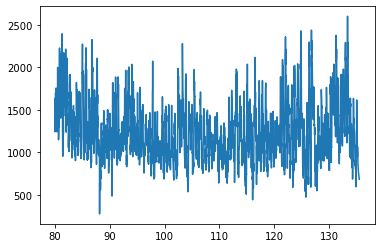

In [3]:
depth = data_Fe[:,0]
depth_lims = depth[0], depth[-1]
# depth_lims = 90, 125
ind = (depth>=depth_lims[0]) & (depth<=depth_lims[1])
y_data = data_Fe[ind,1]
depth = depth[ind]
# depth_original = depth 
lowess = sm.nonparametric.lowess(y_data, depth, frac=.3).T
# y = y_ori - lowess[1]
y = y_data-lowess[1]
# y = y_data - y_data.mean()
y = y/y.std()
%matplotlib inline

plt.figure()
plt.plot(data_Fe[:,0], data_Fe[:,1])

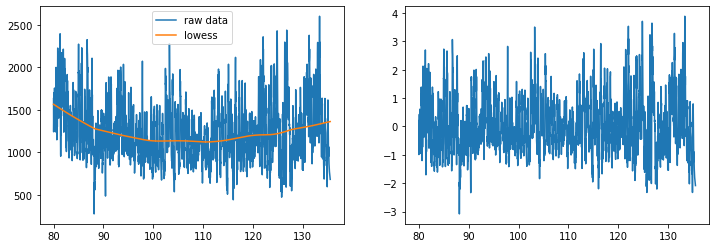

In [4]:
%matplotlib inline
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(depth, y_data, label="raw data")
plt.plot(depth, lowess[1], label="lowess")
plt.legend()
# plt.plot(depth, ydata_ma)
# plt.plot(depth, ydata-ydata_ma)
plt.subplot(1,2,2)
plt.plot(depth, y)


Age model by visual tuning

In [5]:
df_age_model = pd.read_csv("ODP1260/ggge20293-sup-0011-suppinfo06.txt", delimiter="\t")
depth_age_nominal = df_age_model[["Depth (rmcd)", "La2004 age (Ma)"]].to_numpy().T
depth_age_nominal = depth_age_nominal[:,:-1]
# depth_age_nominal[1] = depth_age_nominal[1]*1e3
df_age_model

Depth (rmcd)  La2004 age (Ma)
0           37.60           39.786
1           44.42           40.094
2           45.04           40.122
3           45.48           40.145
4           45.86           40.165
..            ...              ...
177        133.96           43.943
178        134.50           43.967
179        135.06           43.987
180        135.62           44.008
181           NaN              NaN

[182 rows x 2 columns]

In [6]:
# ind = (depth_age_nominal[0]>=depth_lims[0]) & (depth_age_nominal[0]<=depth_lims[1])
# depth_age_nominal = depth_age_nominal[:, ind]
invSR_nominal = np.gradient(depth_age_nominal[1], depth_age_nominal[0])
func_invSR_nominal = interp1d(depth_age_nominal[0], invSR_nominal, kind="nearest" )
func_time_nominal = interp1d(depth_age_nominal[0], depth_age_nominal[1] )
# invSR_nominal = invSR_nominal[ind]
# SR_nominal = 1/invSR_nominal

Text(0.5, 0, 'm')

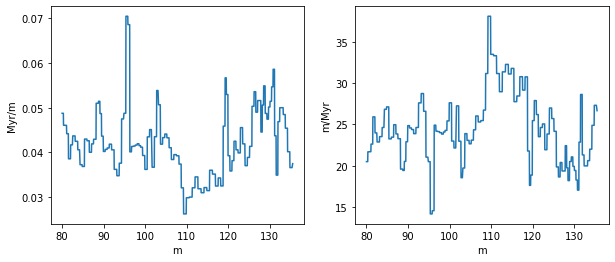

In [7]:
plt.figure(figsize=(10,4))
# plt.plot(*depth_age_nominal)
plt.subplot(1,2,1)
# plt.step(depth_age_nominal[0], invSR_nominal, where="mid")
plt.plot(depth, func_invSR_nominal(depth))
plt.ylabel("Myr/m")
plt.xlabel("m")
plt.subplot(1,2,2)
plt.plot(depth, 1/func_invSR_nominal(depth))
# plt.step(depth_age_nominal[0], SR_nominal)
plt.ylabel("m/Myr")
plt.xlabel("m")

# Model

In [7]:
coef_time = 1e6


b_k = np.array([0.018986, 0.016354, 0.013055, 0.008849, 0.004248])/0.022 #
muy_k = np.array([4.257564, 7.456665, 17.910194, 17.366595, 5.579378])
phi_k = np.array([30.739, -157.801, 140.577, -55.885, 77.107])
phi_k = phi_k/180/3600*np.pi
muy_k = muy_k/180/3600*np.pi*coef_time

p0 = 50.467718
# p0 = 40
p0 = p0/180/3600*np.pi*coef_time

# b_k

ordering = [4, 1, 3, 2, 0]
b_k = b_k[ordering]
g_k = muy_k[ordering]
phi_k = phi_k[ordering]


# fe_k = np.array([3.199279, 13.651920, 10.456224, 13.109803, 9.909679])
# fe_k = fe_k/180/3600*np.pi*coef_time

fe_k =  np.array([g_k[1]-g_k[4], g_k[3]-g_k[4] , g_k[3]-g_k[1], g_k[2]-g_k[4], g_k[2]-g_k[1]])

fs = np.hstack([g_k + p0, fe_k])
print(fs)
print(2*np.pi/fs)

[271.72398927 280.82533348 328.87002991 331.50547223 265.31565416
  15.50967932  66.18981807  50.68013875  63.55437575  48.04469643]
[0.02312341 0.022374   0.01910538 0.01895349 0.02368192 0.40511381
 0.09492677 0.12397727 0.09886314 0.13077792]


## Optimize

In [22]:
# N_population = 128 # number of individual in population 
# N_generations_max = 12
N_genes = 20 # number of intial gene in an individial of the population 
# depth_genes = np.linspace(0,1,N_genes)
depth_genes = np.linspace(depth_lims[0], depth_lims[1], N_genes)
# true_genes = func_inv_SR(depth_genes)
invSR_lims = [0.02, 0.1]
# fs = muy_k + p0
fs = np.hstack([g_k + p0, fe_k])
# fs =  np.array([f1, f2])
# interpolator = interpolate_Akima
interpolator = interpolate_CubicSpline
invSR_to_predx =  partial(invSR_to_pred,  data=[depth, y], invSR_lims=invSR_lims, fs=fs, interpolator=interpolator)

n_pieces = 2
metric_optimal = metric_piecewise([depth_genes, func_invSR_nominal(depth_genes)], [depth, y], fs, interpolator, n_pieces)
print(metric_optimal)
# invSR_all = np.zeros((N_generations_max, N_population, N_genes))
# invSR_ini = np.random.rand(N_population, N_genes)*invSR_lims[1]
# invSR_all[0] = invSR_ini
# metric_all = np.zeros((N_generations_max, N_population))
# metric_ini = np.array([metric([depth_genes, invSR_ini_i], [depth, y], fs, interpolator, metric_type="BIC") for invSR_ini_i in invSR_ini])
# metric_all[0] = metric_ini
# interpolator = interpolate_CubicSpline
data = [depth, y]
problem = invSRinference(depth_genes, invSR_lims, interpolator, data, fs, n_pieces=n_pieces, metric=metric_piecewise)
out = {}
problem._evaluate(np.random.rand(len(depth_genes)), out)
out

[0.13400737 0.15253567]


{'F': array([-0.02776016,  0.00190853])}

## With nominal age model

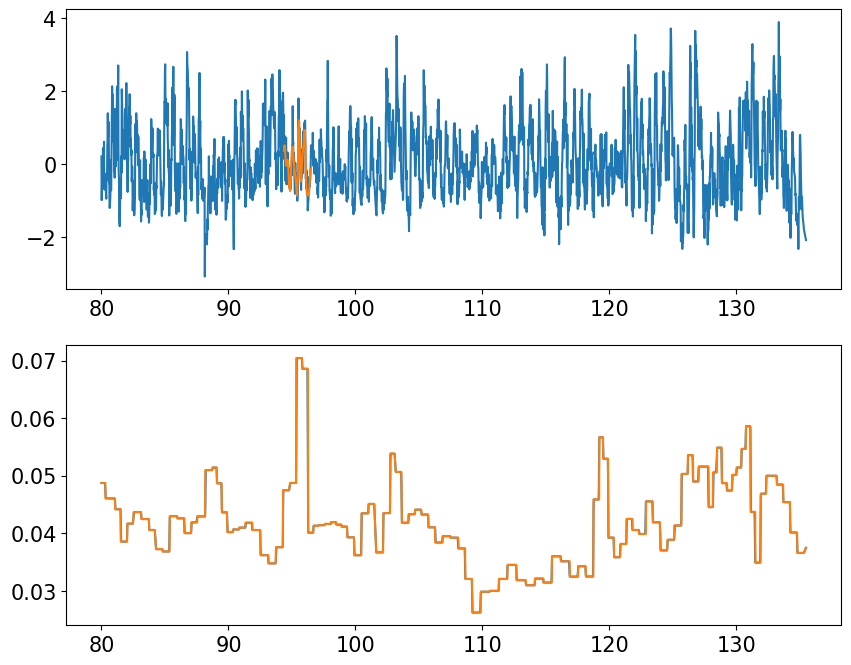

In [12]:
%matplotlib inline
depth_genes_test = np.linspace(depth_lims[0], depth_lims[1], 1000)

i0= 700; istep = 100
data = depth[i0:i0+istep], y[i0:i0+istep]
invSR_to_predx =  partial(invSR_to_pred,  data=data, invSR_lims=invSR_lims, fs=fs, interpolator=interpolator)
time, y_pred = invSR_to_predx([depth_genes_test, func_invSR_nominal(depth_genes_test)])
plt.figure(figsize=(10,8))
plt.subplot(2, 1,1)
plt.plot(depth, y)
plt.plot(data[0], y_pred)
# plt.plot(depth, y_pred)

# plt.plot(func_time_nominal(depth)-func_time_nominal(depth[0]), y)
# plt.plot(time, y_pred)
plt.subplot(2,1,2)
# plt.plot(depth, y)
# plt.plot(depth, y_pred)
invSR_reconstruct = interpolator([depth_genes_test, func_invSR_nominal(depth_genes_test)], depth )
plt.plot(depth, invSR_reconstruct)
plt.plot(depth, func_invSR_nominal(depth))

# plt.plot(depth, time)

## GA

In [23]:
algorithm = NSGA2(
    pop_size=100,
    # n_offsprings=100,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

termination = get_termination("n_gen", 100)

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

# X = res.X
# F = res.F

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |     10 |             - |             -
     2 |      200 |      6 |  0.0323674477 |         ideal
     3 |      300 |      9 |  0.2422574827 |         ideal
     4 |      400 |      8 |  0.2084706390 |         ideal
     5 |      500 |      9 |  0.0357704476 |         ideal
     6 |      600 |      7 |  0.1805086311 |         ideal
     7 |      700 |      8 |  0.0565526082 |         ideal
     8 |      800 |      7 |  0.2459397535 |         ideal
     9 |      900 |     10 |  0.0399639518 |         ideal
    10 |     1000 |     14 |  0.0250977586 |         ideal
    11 |     1100 |     14 |  0.0210439298 |             f
    12 |     1200 |      9 |  0.3000820920 |         ideal
    13 |     1300 |      7 |  0.0277767114 |         ideal
    14 |     1400 |      7 |  0.0546899512 |         ideal
    15 |     1500 |     13 |  0.0947379876 |         ideal
    16 |     1600 |     16 |  0.0100604927 |            

In [56]:
# res = res_ensemble[-1]
# depth_genes = depth_genes_ensemble[-1]

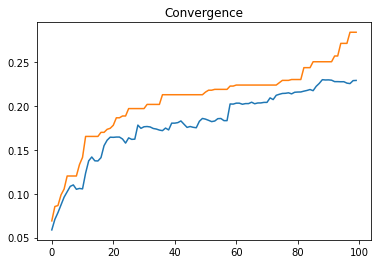

In [24]:
# opt = -np.array([e.opt[0].F for e in res.history])
opt_mean = np.array([ np.mean([-eiopt.F for eiopt in e.opt]) for e in res.history])
opt_max = np.array([ np.max(np.mean(np.array([-eiopt.F for eiopt in e.opt]), axis=1)) for e in res.history])

plt.figure()
plt.title("Convergence")
# plt.plot(opt.mean(axis=1), "--")
plt.plot(opt_mean)
plt.plot(opt_max)

# plt.yscale("log")
plt.show()


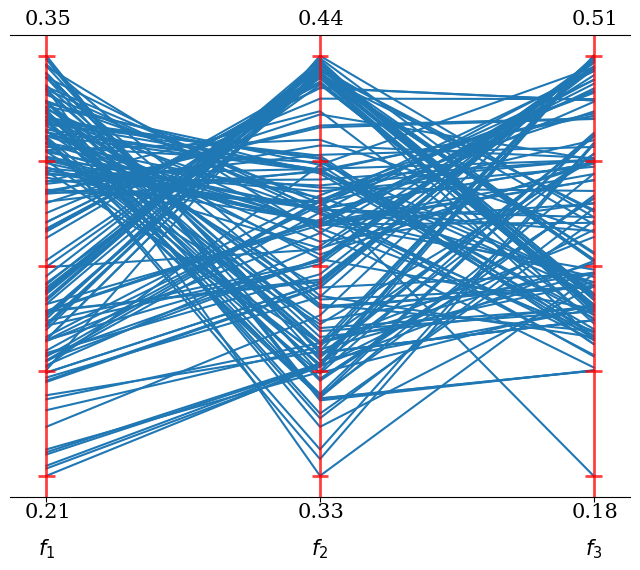

In [94]:
from pymoo.visualization.pcp import PCP
PCP().add(-res.F).show()


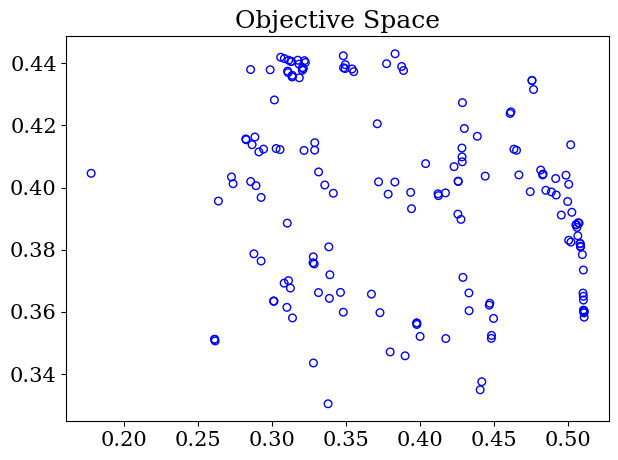

In [99]:
%matplotlib inline
plt.figure(figsize=(7, 5))
plt.scatter(-res.F[:, 2], -res.F[:, 1], s=30, facecolors='none', edgecolors='blue')
f1min, f1max = -res.F[:,0].min(), -res.F[:,1].max()
f1grid = np.linspace(0, 1, 100)

# for i in range(res.F.shape[0]):
#     plt.plot(f1grid, -res.F[i,0] + -res.F[i,1] - f1grid, color="black",alpha=0.5)
plt.title("Objective Space")
# plt.xlim([0,1])
# plt.ylim([0,1])
# plt.plot(metric_optimal[0],metric_optimal[1], "d", color="black")
plt.show()


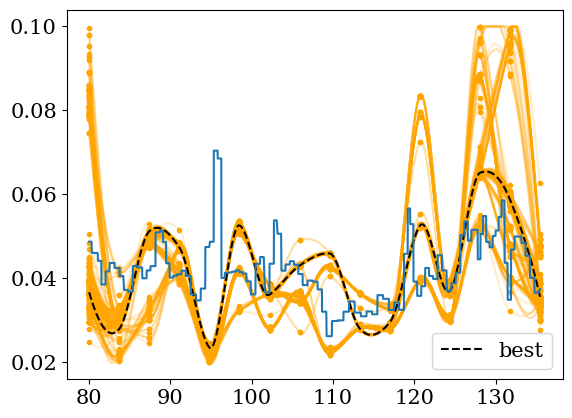

In [107]:
%matplotlib inline
# invSR_interpolate = interpolator([depth_genes, invSR_best], depth)
res.F.shape, res.X.shape
arg_best = np.argmin(res.F.sum(axis=1)/2)
invSR_best = res.X[arg_best]
fig = plt.figure()
for i in range(res.F.shape[0]):
    plt.plot(depth_genes, res.X[i], '.',color="orange")
    invSR_interpolate = interpolator([depth_genes, res.X[i]], depth)
    invSR_interpolate[invSR_interpolate<invSR_lims[0]] = invSR_lims[0]
    invSR_interpolate[invSR_interpolate>invSR_lims[1]] = invSR_lims[1]
    plt.plot(depth, invSR_interpolate, "-", alpha=0.2,color="orange")
# plt.plot(depth, invSR, color="red")
plt.plot(depth, interpolator([depth_genes, invSR_best], depth), "--", color="black", label="best")
# plt.plot(depth, interpolator([depth_genes, func_invSR_nominal(depth_genes)], depth), color="red", label="nominal")
plt.plot(depth, func_invSR_nominal(depth))
# invSR_interpolate[invSR_interpolate<0] = 0
plt.legend()
# time = sp.integrate.cumulative_trapezoid(invSR_interpolate, depth, initial=0)
# X = generate_X_linReg(np.ones_like(fs), fs, time)

# reg_model = LinearRegression().fit(X, y_data)
# y_pred = reg_model.predict(X)

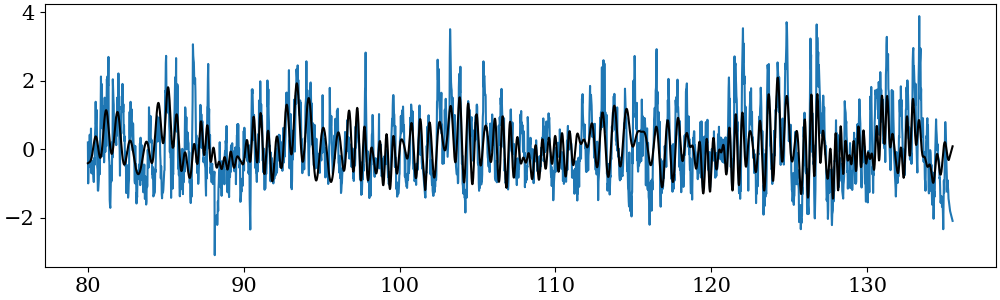

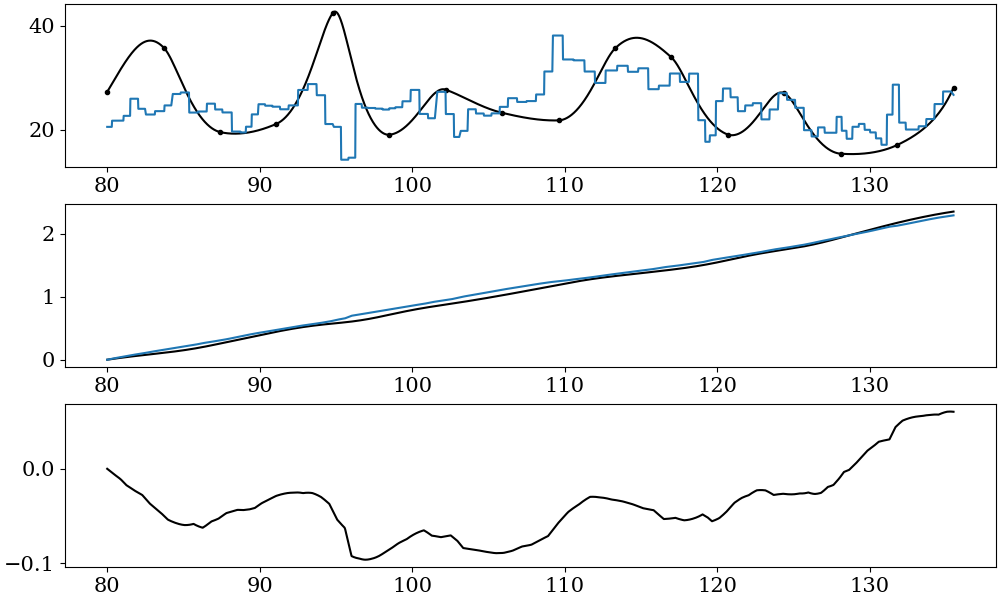

In [108]:
%matplotlib widget
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
ax.plot(depth, y)
# axs[0].plot(depth_age[0], (depth_age[1]-depth_age[1,0] ))
# for i in range(res.F.shape[0]):

#     # invSR_interpolate = interpolator([depth_genes, res.X[i]], depth)
#     time, y_pred = invSR_to_predx([depth_genes, res.X[i]])
    
#     axs[1].plot(depth, y_pred, alpha=0.1, color="black")
#     axs[0].plot(depth, time, alpha=0.3, color="black")
    
time_best, y_pred = invSR_to_predx([depth_genes, invSR_best])

# axs[0].plot(depth, time, color="black")
# 
ax.plot(depth, y_pred, color="black")

time_nominal, y_pred = invSR_to_predx([depth_genes, func_invSR_nominal(depth_genes)])
# axs[1].plot(depth, y_pred,  color="red")
# axs[0].plot(depth, time, color="red")


# axs[1].plot(depth, interpolator([depth_genes, res.X[arg_best]], depth), color="black")
# axs[1].plot(depth_genes, res.X[arg_best], '.', color="black")
# axs[1].plot(depth, func_invSR_nominal(depth))
fig, axs = plt.subplots(3, 1, constrained_layout=True, figsize=(10,6))

axs[0].plot(depth, 1/interpolator([depth_genes, res.X[arg_best]], depth), color="black")
axs[0].plot(depth_genes, 1/res.X[arg_best], '.', color="black")
axs[0].plot(depth, 1/func_invSR_nominal(depth))

axs[1].plot(depth, time_best, color="black")
# axs[1].plot(depth, time_nominal)
axs[1].plot(depth, func_time_nominal(depth)-func_time_nominal(depth[0]))
# axs[1].plot(depth, time_best-time_nominal, color="black")
axs[2].plot(depth, time_best-func_time_nominal(depth)+func_time_nominal(depth[0]), color="black")


# axs[0].plot(depth, interpolator([depth_genes, res.X[i]], depth))

# for i in range(2):
#     axs[i].set_xlim([90, 100])

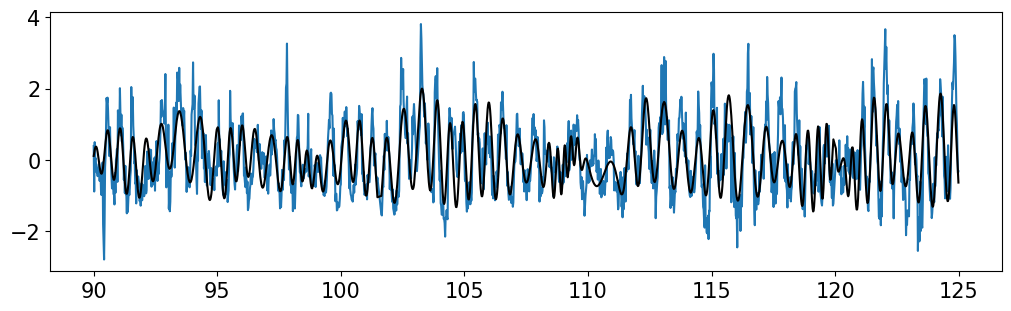

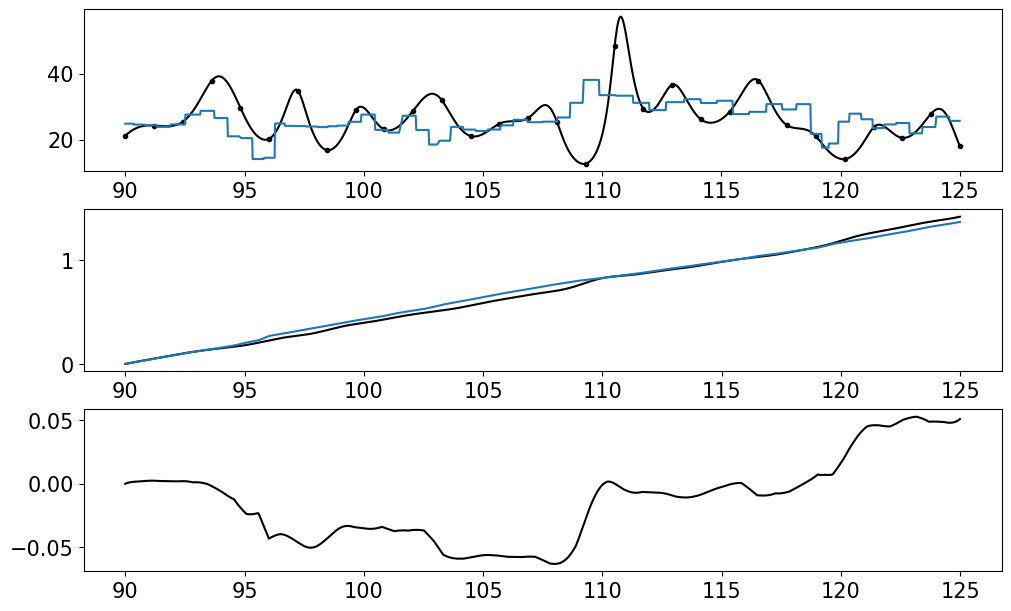

In [97]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
ax.plot(depth, y)
# axs[0].plot(depth_age[0], (depth_age[1]-depth_age[1,0] ))
# for i in range(res.F.shape[0]):

#     # invSR_interpolate = interpolator([depth_genes, res.X[i]], depth)
#     time, y_pred = invSR_to_predx([depth_genes, res.X[i]])
    
#     axs[1].plot(depth, y_pred, alpha=0.1, color="black")
#     axs[0].plot(depth, time, alpha=0.3, color="black")
    
time_best, y_pred = invSR_to_predx([depth_genes, invSR_best])

# axs[0].plot(depth, time, color="black")
# 
ax.plot(depth, y_pred, color="black")

time_nominal, y_pred = invSR_to_predx([depth_genes, func_invSR_nominal(depth_genes)])
# axs[1].plot(depth, y_pred,  color="red")
# axs[0].plot(depth, time, color="red")


# axs[1].plot(depth, interpolator([depth_genes, res.X[arg_best]], depth), color="black")
# axs[1].plot(depth_genes, res.X[arg_best], '.', color="black")
# axs[1].plot(depth, func_invSR_nominal(depth))
fig, axs = plt.subplots(3, 1, constrained_layout=True, figsize=(10,6))

axs[0].plot(depth, 1/interpolator([depth_genes, res.X[arg_best]], depth), color="black")
axs[0].plot(depth_genes, 1/res.X[arg_best], '.', color="black")
axs[0].plot(depth, 1/func_invSR_nominal(depth))

axs[1].plot(depth, time_best, color="black")
# axs[1].plot(depth, time_nominal)
axs[1].plot(depth, func_time_nominal(depth)-func_time_nominal(depth[0]))
# axs[1].plot(depth, time_best-time_nominal, color="black")
axs[2].plot(depth, time_best-func_time_nominal(depth)+func_time_nominal(depth[0]), color="black")


# axs[0].plot(depth, interpolator([depth_genes, res.X[i]], depth))

# for i in range(2):
#     axs[i].set_xlim([90, 100])

### In search for optimial number of genes

In [9]:

invSR_lims = [0.02, 0.1]
fs = np.hstack([g_k + p0, fe_k])
# interpolator = interpolate_Akima
interpolator = interpolate_CubicSpline
invSR_to_predx =  partial(invSR_to_pred,  data=[depth, y], invSR_lims=invSR_lims, fs=fs, interpolator=interpolator)
n_pieces = 2
# metric_optimal = metric_piecewise([depth_genes, func_invSR_nominal(depth_genes)], [depth, y], fs, interpolator, n_pieces)
# print(metric_optimal)
# invSR_all = np.zeros((N_generations_max, N_population, N_genes))
# invSR_ini = np.random.rand(N_population, N_genes)*invSR_lims[1]
# invSR_all[0] = invSR_ini
# metric_all = np.zeros((N_generations_max, N_population))
# metric_ini = np.array([metric([depth_genes, invSR_ini_i], [depth, y], fs, interpolator, metric_type="BIC") for invSR_ini_i in invSR_ini])
# metric_all[0] = metric_ini
interpolator = interpolate_CubicSpline
data = [depth, y]
problem = invSRinference(depth_genes, invSR_lims, interpolator, data, fs, n_pieces=n_pieces, metric=metric_piecewise)
out = {}
problem._evaluate(np.random.rand(len(depth_genes)), out)
out

{'F': array([-0.03525637, -0.02560138])}

In [49]:
def maxlogL_to_BIC(maxlogL, n_params, n_data):
    return n_params*np.log(n_data) - 2*maxlogL
def maxlogL_to_AIC(maxlogL, n_params):
    return n_params*2 - 2*maxlogL

In [10]:
class Callback_getF(Callback):

    def __init__(self) -> None:
        super().__init__()
        self.data["best"] = []

    def notify(self, algorithm):
        b = algorithm.pop.get("F").mean(axis=1).min()
        self.data["best"].append(b)

In [57]:
N_trial = 4
N_genes_distinct = np.arange(2, 30, 1)
N_genes_enemble = np.array([ np.array([i]*N_trial)  for i in  N_genes_distinct]).flatten()
depth_genes_ensemble = [np.linspace(depth_lims[0], depth_lims[1],N_genes) for N_genes in N_genes_enemble] 
N_ensemble = len(depth_genes_ensemble)
len(N_genes_enemble)

112

In [68]:
algorithm = NSGA2(
    pop_size=400,
    # n_offsprings=100,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)
N_generations = 1000
termination = get_termination("n_gen", N_generations)

# N_genes_enemble = np.arange(10, 60, 4)
# N_genes_enemble = np.array([24]*10)
# depth_genes_ensemble = [np.linspace(depth_lims[0], depth_lims[1], N_genes) for N_genes in N_genes_enemble] 
# N_ensemble = len(depth_genes_ensemble)

N_trial = 4
N_genes_distinct = np.arange(2, 60, 2)
N_genes_enemble = np.array([ np.array([i]*N_trial)  for i in  N_genes_distinct]).flatten()
depth_genes_ensemble = [np.linspace(depth_lims[0], depth_lims[1],N_genes) for N_genes in N_genes_enemble] 

N_ensemble = len(depth_genes_ensemble)


problems = [invSRinference(depth_genes, invSR_lims, interpolator, data, fs, n_pieces=2, metric=metric_piecewise) for depth_genes in depth_genes_ensemble  ] 


res_ensemble = Parallel(n_jobs=N_ensemble, verbose=100)(delayed(minimize)(problem, algorithm, termination, 
                                                                          save_history=False, callback=Callback_getF())
                                                        for problem in problems)

[Parallel(n_jobs=116)]: Using backend LokyBackend with 116 concurrent workers.
[Parallel(n_jobs=116)]: Done   1 tasks      | elapsed: 27.5min
[Parallel(n_jobs=116)]: Done   3 out of 116 | elapsed: 29.6min remaining: 1115.7min
[Parallel(n_jobs=116)]: Done   5 out of 116 | elapsed: 30.7min remaining: 681.6min
[Parallel(n_jobs=116)]: Done   7 out of 116 | elapsed: 31.2min remaining: 486.6min
[Parallel(n_jobs=116)]: Done   9 out of 116 | elapsed: 32.0min remaining: 380.0min
[Parallel(n_jobs=116)]: Done  11 out of 116 | elapsed: 32.1min remaining: 306.5min
[Parallel(n_jobs=116)]: Done  13 out of 116 | elapsed: 32.3min remaining: 256.0min
[Parallel(n_jobs=116)]: Done  15 out of 116 | elapsed: 32.9min remaining: 221.8min
[Parallel(n_jobs=116)]: Done  17 out of 116 | elapsed: 33.0min remaining: 192.3min
[Parallel(n_jobs=116)]: Done  19 out of 116 | elapsed: 33.3min remaining: 170.0min
[Parallel(n_jobs=116)]: Done  21 out of 116 | elapsed: 33.4min remaining: 151.2min
[Parallel(n_jobs=116)]: Don

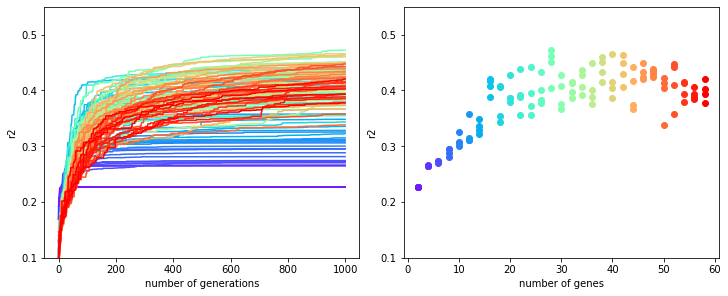

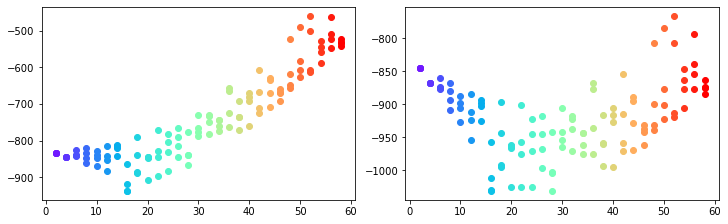

In [71]:
# opt = -np.array([e.opt[0].F for e in res.history])
# opt_mean = np.array([ np.mean([-eiopt.F for eiopt in e.opt]) for e in res.history])
%matplotlib inline
fig = plt.figure(constrained_layout=True, figsize=(10,4))
plt.title("Convergence")
# gs1 = fig.add_gridspec(nrows=1, ncols=2, hspace=0.05, wspace=0.05,
                    #    height_ratios=(6, 4), width_ratios=(35, 65))
# ax1 = fig.add_subplot(gs1[0, 0])
# ax2 = fig.add_subplot(gs1[0, 1])
plt.subplot(1,2,1)

cmap = plt.get_cmap("rainbow")

opt_max_ensemble = np.zeros([N_ensemble,N_generations])
for i in range(N_ensemble):
    res = res_ensemble[i]
    opt_max_ensemble[i] = -np.array(res.algorithm.callback.data["best"])

    # opt_max_ensemble[i] = np.array([ np.max(np.mean(np.array([-eiopt.F for eiopt in e.opt]), axis=1)) for e in res.history])

    # plt.plot(opt_max_ensemble[i], color=cmap(i/N_ensemble))
    plt.plot(opt_max_ensemble[i], color=cmap(N_genes_enemble[i]/N_genes_enemble[-1]))


# metric_optimal = metric_piecewise([depth, func_inv_SR(depth)], [depth, y], fs, interpolator, n_pieces)
plt.ylabel("r2")
plt.xlabel("number of generations")
plt.ylim([0.1, 0.55])
# plt.axhline(metric_optimal.mean(), color="k")

# plt.yscale("log")
plt.subplot(1,2,2)
# ax2 = fig.add_subplot(gs1[0, 1])

# plt.plot(N_genes_enemble, opt_max_ensemble[:,-1], '.-')
# [ for i in range(N_ensemble)]
for i in range(N_ensemble):
    plt.scatter(N_genes_enemble[i], opt_max_ensemble[i,-1], color=cmap(N_genes_enemble[i]/N_genes_enemble[-1]))
    # metric_optimal = metric_piecewise([depth_genes_ensemble[i], func_inv_SR(depth_genes_ensemble[i])], [depth, y], fs, interpolator, n_pieces)
    # plt.axhline(metric_optimal.mean() , color=cmap(i/N_ensemble),zorder=-10)
# plt.axhline(metric_optimal.mean(), color="k")

plt.xlabel("number of genes")
plt.ylabel("r2")
plt.ylim([0.1, 0.55])
# plt.savefig("r2_Ngenesb.png", dpi=200)


fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10,3))
cmap = plt.get_cmap("rainbow")
rho = 0.8
sigma = 0.8
for i, res in enumerate(res_ensemble):
    res = res_ensemble[i]
    # if i<=40:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    # maxlogL  = log_likelihood_rednoise([depth_genes, func_inv_SR(depth_genes)], data, fs, [rho_true, sigma_true], interpolator=interpolate_CubicSpline)
    maxlogL  = log_likelihood_rednoise([depth_genes, res.X[arg_best]], data, fs, [sigma, rho], interpolator=interpolate_CubicSpline)

    # plt.scatter(N_genes_enemble[i], maxlogL, color=cmap(i/N_ensemble))
    axs[0].scatter(N_genes_enemble[i], maxlogL_to_BIC(maxlogL, N_genes_enemble[i], len(y)), color=cmap(N_genes_enemble[i]/N_genes_enemble[-1]))
    axs[1].scatter(N_genes_enemble[i], maxlogL_to_AIC(maxlogL, N_genes_enemble[i]), color=cmap(N_genes_enemble[i]/N_genes_enemble[-1]))

C:\Users\hhnam\AppData\Local\Temp\ipykernel_9016\865491720.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


(0.1, 0.47)

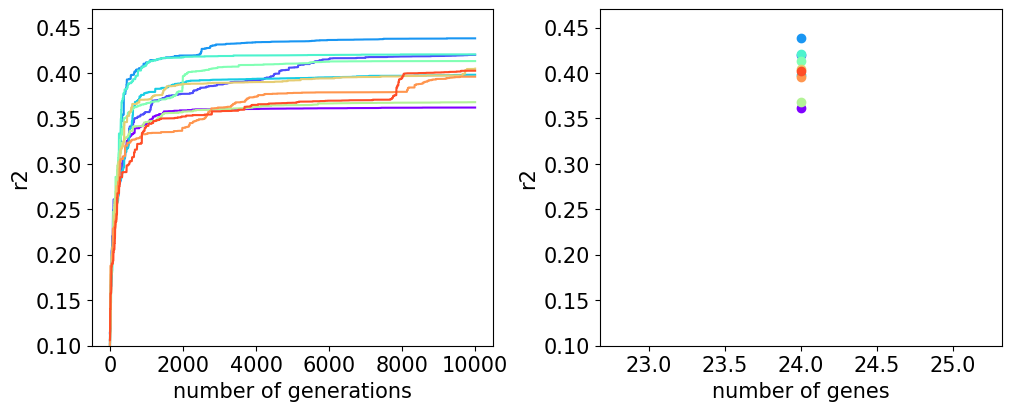

In [25]:
# opt = -np.array([e.opt[0].F for e in res.history])
# opt_mean = np.array([ np.mean([-eiopt.F for eiopt in e.opt]) for e in res.history])
%matplotlib inline
fig = plt.figure(constrained_layout=True, figsize=(10,4))
plt.title("Convergence")
# gs1 = fig.add_gridspec(nrows=1, ncols=2, hspace=0.05, wspace=0.05,
                    #    height_ratios=(6, 4), width_ratios=(35, 65))
# ax1 = fig.add_subplot(gs1[0, 0])
# ax2 = fig.add_subplot(gs1[0, 1])
plt.subplot(1,2,1)

cmap = plt.get_cmap("rainbow")

opt_max_ensemble = np.zeros([N_ensemble,N_generations])
for i in range(N_ensemble):
    res = res_ensemble[i]
    opt_max_ensemble[i] = -np.array(res.algorithm.callback.data["best"])

    # opt_max_ensemble[i] = np.array([ np.max(np.mean(np.array([-eiopt.F for eiopt in e.opt]), axis=1)) for e in res.history])

    # plt.plot(opt_max_ensemble[i], color=cmap(i/N_ensemble))
    plt.plot(opt_max_ensemble[i], color=cmap(i/N_ensemble))
plt.ylabel("r2")
plt.xlabel("number of generations")
plt.ylim([0.1, 0.47])
# plt.yscale("log")
plt.subplot(1,2,2)
# ax2 = fig.add_subplot(gs1[0, 1])

# plt.plot(N_genes_enemble, opt_max_ensemble[:,-1], '.-')
[plt.scatter(N_genes_enemble[i], opt_max_ensemble[i,-1], color=cmap(i/N_ensemble)) for i in range(N_ensemble)]
plt.xlabel("number of genes")
plt.ylabel("r2")
plt.ylim([0.1, 0.47])
# plt.savefig("r2_Ngenesb.png", dpi=200)

In [30]:
N_genes_enemble

array([ 2,  2,  2,  2,  3,  3,  3,  3,  4,  4,  4,  4,  5,  5,  5,  5,  6,
        6,  6,  6,  7,  7,  7,  7,  8,  8,  8,  8,  9,  9,  9,  9, 10, 10,
       10, 10, 11, 11, 11, 11, 12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14,
       14, 15, 15, 15, 15, 16, 16, 16, 16, 17, 17, 17, 17, 18, 18, 18, 18,
       19, 19, 19, 19, 20, 20, 20, 20, 21, 21, 21, 21, 22, 22, 22, 22, 23,
       23, 23, 23, 24, 24, 24, 24, 25, 25, 25, 25, 26, 26, 26, 26, 27, 27,
       27, 27, 28, 28, 28, 28, 29, 29, 29, 29])

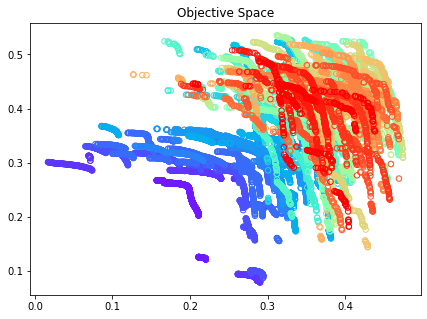

In [73]:
%matplotlib inline
plt.figure(figsize=(7, 5))
for i in range(N_ensemble):
    res = res_ensemble[i]
    plt.scatter(-res.F[:, 0], -res.F[:, 1], s=30, facecolors='none', color=cmap(N_genes_enemble[i]/N_genes_enemble[-1]))
f1min, f1max = -res.F[:,0].min(), -res.F[:,1].max()
f1grid = np.linspace(0, 1, 100)

# for i in range(res.F.shape[0]):
#     plt.plot(f1grid, -res.F[i,0] + -res.F[i,1] - f1grid, color="black",alpha=0.5)
plt.title("Objective Space")
# plt.xlim([0,1])
# plt.ylim([0,1])
# plt.plot(metric_optimal[0],metric_optimal[1], "d", color="black")
plt.show()


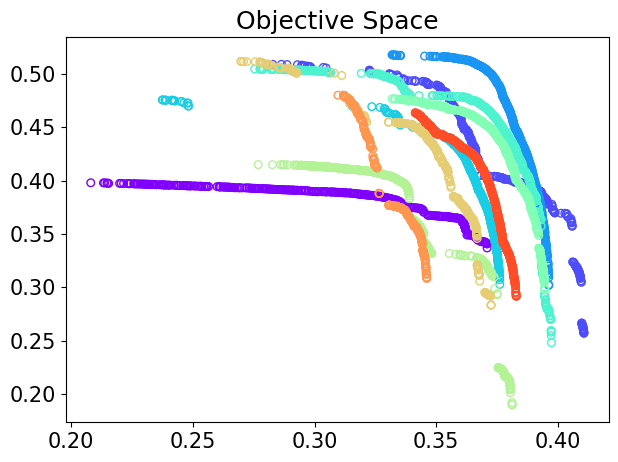

In [26]:
%matplotlib inline
plt.figure(figsize=(7, 5))
for i in range(N_ensemble):
    res = res_ensemble[i]
    plt.scatter(-res.F[:, 0], -res.F[:, 1], s=30, facecolors='none', color=cmap(i/N_ensemble))
f1min, f1max = -res.F[:,0].min(), -res.F[:,1].max()
f1grid = np.linspace(0, 1, 100)

# for i in range(res.F.shape[0]):
#     plt.plot(f1grid, -res.F[i,0] + -res.F[i,1] - f1grid, color="black",alpha=0.5)
plt.title("Objective Space")
# plt.xlim([0,1])
# plt.ylim([0,1])
# plt.plot(metric_optimal[0],metric_optimal[1], "d", color="black")
plt.show()


C:\Users\hhnam\AppData\Local\Temp\ipykernel_16480\865491720.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


(0.1, 0.47)

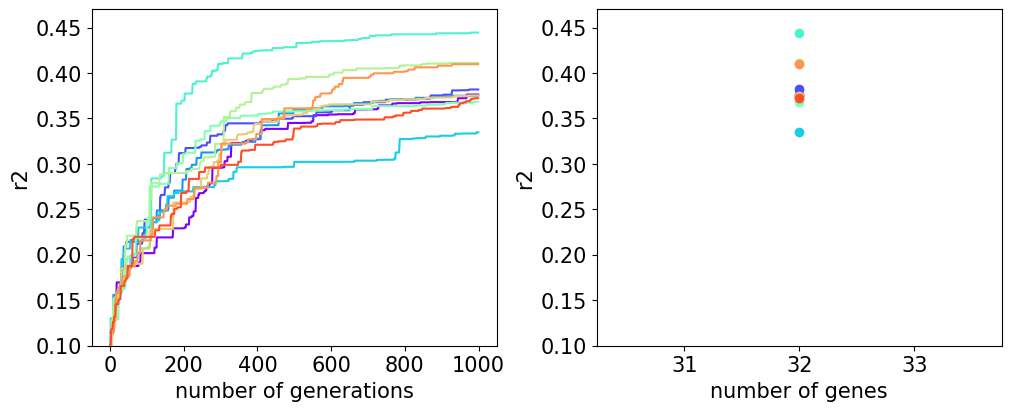

In [21]:
# opt = -np.array([e.opt[0].F for e in res.history])
# opt_mean = np.array([ np.mean([-eiopt.F for eiopt in e.opt]) for e in res.history])
%matplotlib inline
fig = plt.figure(constrained_layout=True, figsize=(10,4))
plt.title("Convergence")
# gs1 = fig.add_gridspec(nrows=1, ncols=2, hspace=0.05, wspace=0.05,
                    #    height_ratios=(6, 4), width_ratios=(35, 65))
# ax1 = fig.add_subplot(gs1[0, 0])
# ax2 = fig.add_subplot(gs1[0, 1])
plt.subplot(1,2,1)

cmap = plt.get_cmap("rainbow")

opt_max_ensemble = np.zeros([N_ensemble,N_generations])
for i in range(N_ensemble):
    res = res_ensemble[i]
    opt_max_ensemble[i] = -np.array(res.algorithm.callback.data["best"])

    # opt_max_ensemble[i] = np.array([ np.max(np.mean(np.array([-eiopt.F for eiopt in e.opt]), axis=1)) for e in res.history])

    # plt.plot(opt_max_ensemble[i], color=cmap(i/N_ensemble))
    plt.plot(opt_max_ensemble[i], color=cmap(i/N_ensemble))
plt.ylabel("r2")
plt.xlabel("number of generations")
plt.ylim([0.1, 0.47])
# plt.yscale("log")
plt.subplot(1,2,2)
# ax2 = fig.add_subplot(gs1[0, 1])

# plt.plot(N_genes_enemble, opt_max_ensemble[:,-1], '.-')
[plt.scatter(N_genes_enemble[i], opt_max_ensemble[i,-1], color=cmap(i/N_ensemble)) for i in range(N_ensemble)]
plt.xlabel("number of genes")
plt.ylabel("r2")
plt.ylim([0.1, 0.47])
# plt.savefig("r2_Ngenesb.png", dpi=200)

C:\Users\hhnam\AppData\Local\Temp\ipykernel_12256\1389198655.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


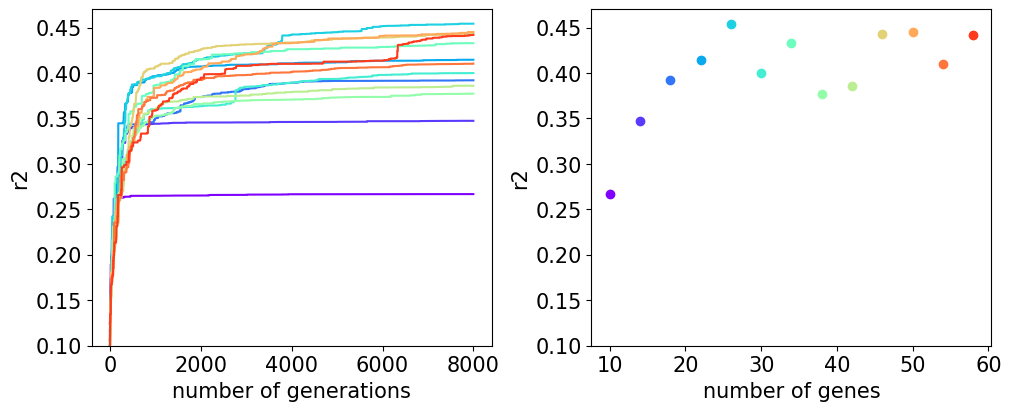

In [15]:
# opt = -np.array([e.opt[0].F for e in res.history])
# opt_mean = np.array([ np.mean([-eiopt.F for eiopt in e.opt]) for e in res.history])
%matplotlib inline
fig = plt.figure(constrained_layout=True, figsize=(10,4))
plt.title("Convergence")
# gs1 = fig.add_gridspec(nrows=1, ncols=2, hspace=0.05, wspace=0.05,
                    #    height_ratios=(6, 4), width_ratios=(35, 65))
# ax1 = fig.add_subplot(gs1[0, 0])
# ax2 = fig.add_subplot(gs1[0, 1])
plt.subplot(1,2,1)

cmap = plt.get_cmap("rainbow")

opt_max_ensemble = np.zeros([N_ensemble,N_generations])
for i in range(N_ensemble):
    res = res_ensemble[i]
    opt_max_ensemble[i] = -np.array(res.algorithm.callback.data["best"])

    # opt_max_ensemble[i] = np.array([ np.max(np.mean(np.array([-eiopt.F for eiopt in e.opt]), axis=1)) for e in res.history])

    # plt.plot(opt_max_ensemble[i], color=cmap(i/N_ensemble))
    plt.plot(opt_max_ensemble[i], color=cmap(i/N_ensemble))
plt.ylabel("r2")
plt.xlabel("number of generations")
plt.ylim([0.1, 0.47])
# plt.yscale("log")
plt.subplot(1,2,2)
# ax2 = fig.add_subplot(gs1[0, 1])

# plt.plot(N_genes_enemble, opt_max_ensemble[:,-1], '.-')
[plt.scatter(N_genes_enemble[i], opt_max_ensemble[i,-1], color=cmap(i/N_ensemble)) for i in range(N_ensemble)]
plt.xlabel("number of genes")
plt.ylabel("r2")
plt.ylim([0.1, 0.47])
# plt.savefig("r2_Ngenesb.png", dpi=200)

In [52]:
interpolator = interpolate_CubicSpline
invSR_to_predx =  partial(invSR_to_pred,  data=data, invSR_lims=invSR_lims, fs=fs, interpolator=interpolator)


[0.34141412 0.46352823]


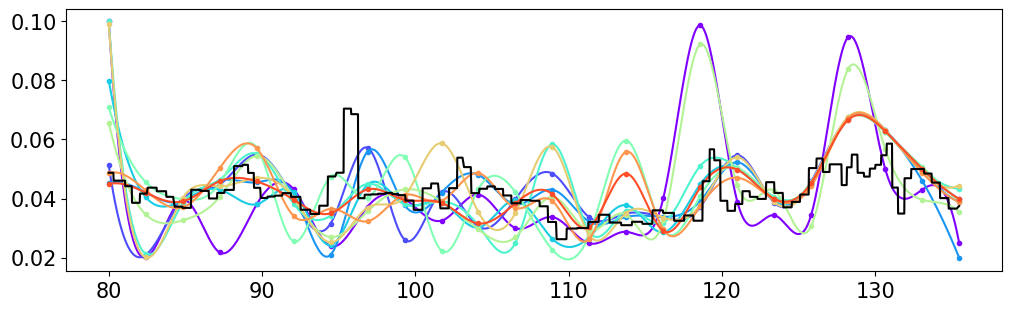

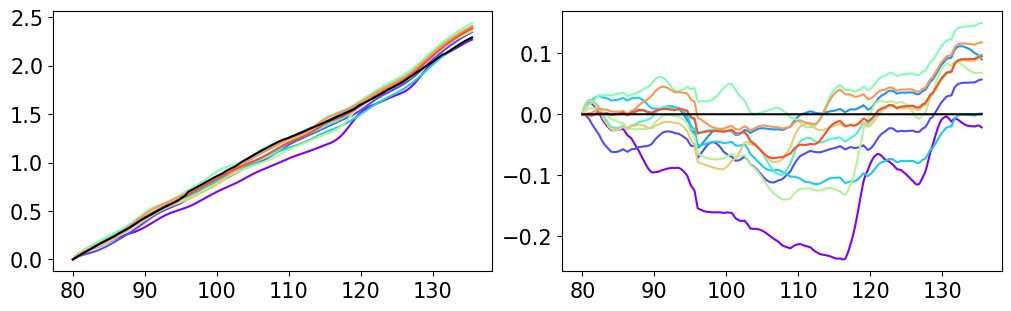

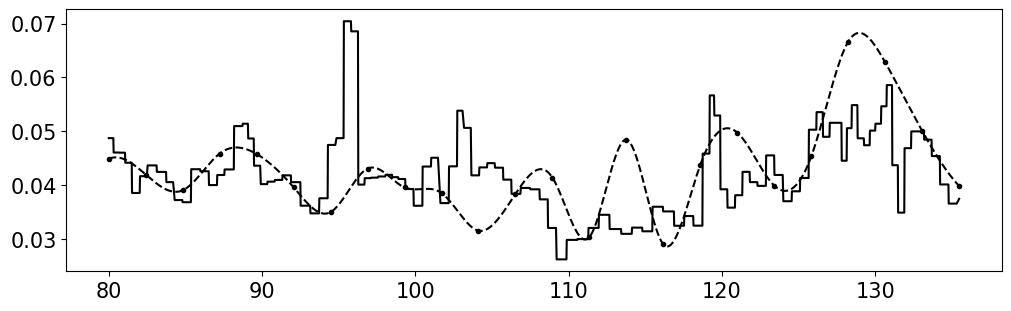

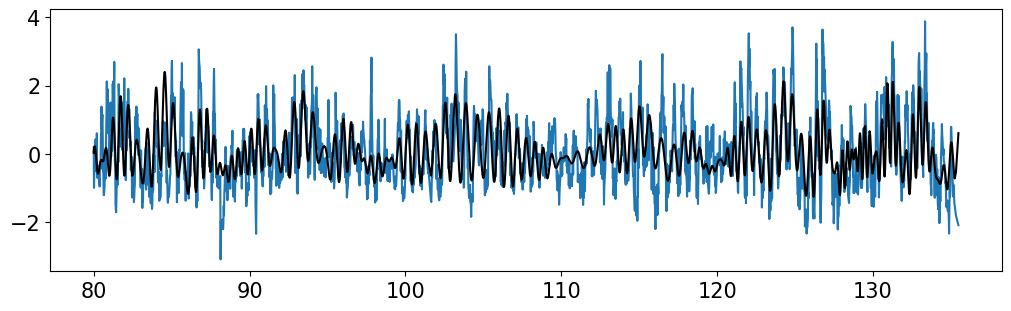

In [57]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
ax.plot(depth, func_invSR_nominal(depth),color="black",zorder=100)
cmap = plt.get_cmap("rainbow")

for i, res in enumerate(res_ensemble):
    # if i<2:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    ax.plot(depth, interpolator([depth_genes, res.X[arg_best]], depth), color=cmap(i/N_ensemble))
    ax.plot(depth_genes, res.X[arg_best], '.', color=cmap(i/N_ensemble))

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10,3))
cmap = plt.get_cmap("rainbow")
for i, res in enumerate(res_ensemble):
    # if i<2:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    time, y_pred = invSR_to_predx([depth_genes, res.X[arg_best]])
    axs[0].plot(depth, time, color=cmap(i/N_ensemble))
    axs[1].plot(depth, time-func_time_nominal(depth)+func_time_nominal(depth[0]), color=cmap(i/N_ensemble))
axs[0].plot(depth, func_time_nominal(depth)-func_time_nominal(depth[0]), color="black")
axs[1].plot(depth, depth*0, color="k")

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
ax.plot(depth, func_invSR_nominal(depth),color="black")
i = -1
res = res_ensemble[i]
depth_genes = depth_genes_ensemble[i]
arg_best = np.argmin(res.F.mean(axis=1))
print(-res.F[arg_best])
ax.plot(depth, interpolator([depth_genes, res.X[arg_best]], depth), "--", color="black")
ax.plot(depth_genes, res.X[arg_best], '.', color="black")
# ax.set_ylim(invSR_lims)

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))

time, y_pred = invSR_to_predx([depth_genes, res.X[arg_best]])
ax.plot(depth, y )
ax.plot(depth, y_pred, color="black")

# ax.plot(time, y )
# ax.plot(time, y_pred, color="black")

[0.32651567 0.49174242]


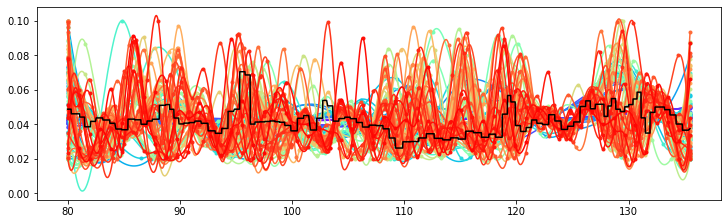

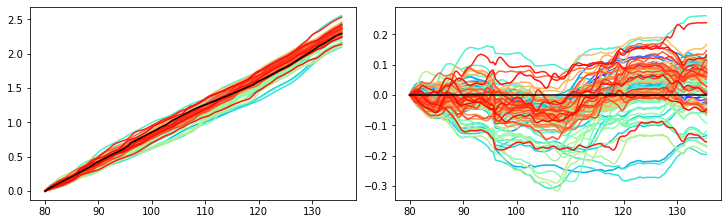

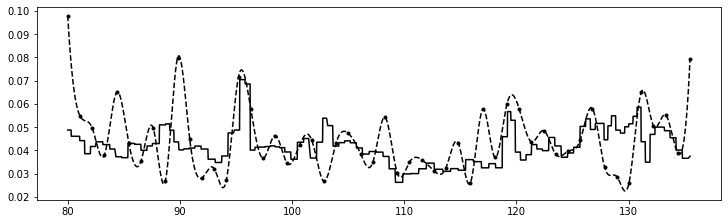

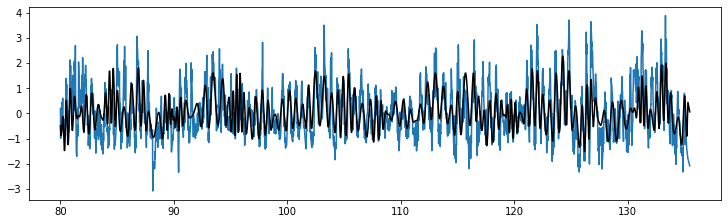

In [72]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
ax.plot(depth, func_invSR_nominal(depth),color="black",zorder=100)
cmap = plt.get_cmap("rainbow")

for i, res in enumerate(res_ensemble):
    # if i<2:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    ax.plot(depth, interpolator([depth_genes, res.X[arg_best]], depth), color=cmap(i/N_ensemble))
    ax.plot(depth_genes, res.X[arg_best], '.', color=cmap(i/N_ensemble))

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10,3))
cmap = plt.get_cmap("rainbow")
for i, res in enumerate(res_ensemble):
# for i, res in enumerate(reversed(res_ensemble)):
    # if i<2:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    time, y_pred = invSR_to_predx([depth_genes, res.X[arg_best]])
    axs[0].plot(depth, time, color=cmap(i/N_ensemble))
    axs[1].plot(depth, time-func_time_nominal(depth)+func_time_nominal(depth[0]), color=cmap(i/N_ensemble))
axs[0].plot(depth, func_time_nominal(depth)-func_time_nominal(depth[0]), color="black")
axs[1].plot(depth, depth*0, color="k")

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
ax.plot(depth, func_invSR_nominal(depth),color="black")
i = -15
res = res_ensemble[i]
depth_genes = depth_genes_ensemble[i]
arg_best = np.argmin(res.F.mean(axis=1))
print(-res.F[arg_best])
ax.plot(depth, interpolator([depth_genes, res.X[arg_best]], depth), "--", color="black")
ax.plot(depth_genes, res.X[arg_best], '.', color="black")
# ax.set_ylim(invSR_lims)

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))

time, y_pred = invSR_to_predx([depth_genes, res.X[arg_best]])
ax.plot(depth, y )
ax.plot(depth, y_pred, color="black")

# ax.plot(time, y )
# ax.plot(time, y_pred, color="black")

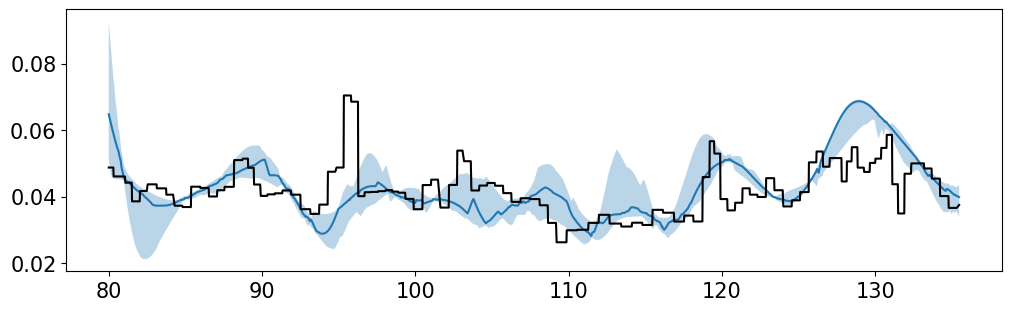

In [60]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
N_indi = 9 
invSR_pop = np.zeros([len(depth), N_ensemble, N_indi])
for i, res in enumerate(res_ensemble):
    # if i<2:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    for j in range(N_indi):
        arg_best = np.argmin(res.F.sum(axis=1))
        invSR_pop[:, i, j] = interpolator([depth_genes, res.X[j]], depth)
        # ax.plot(depth, interpolator([depth_genes, res.X[j]], depth), color="black",alpha=0.1)
        # ax.plot(depth_genes, res.X[j], '.', alpha=0.1, color="black")
invSR_pop = invSR_pop.reshape(len(depth), -1)
ax.plot(depth, np.median(invSR_pop,axis=-1))
ax.fill_between(depth, *np.quantile(invSR_pop, [0.25, 0.75], axis=-1), alpha=0.3)
ax.plot(depth, func_invSR_nominal(depth),color="black",zorder=100)


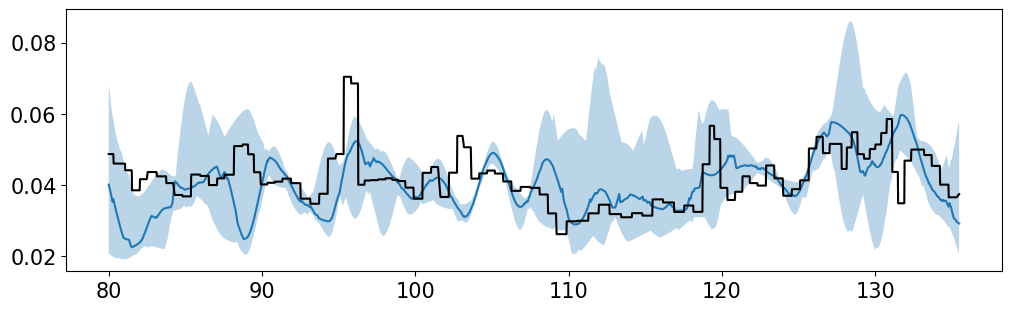

In [26]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
N_indi = 9 
invSR_pop = np.zeros([len(depth), N_ensemble, N_indi])
for i, res in enumerate(res_ensemble):
    # if i<2:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    for j in range(N_indi):
        arg_best = np.argmin(res.F.sum(axis=1))
        invSR_pop[:, i, j] = interpolator([depth_genes, res.X[j]], depth)
        # ax.plot(depth, interpolator([depth_genes, res.X[j]], depth), color="black",alpha=0.1)
        # ax.plot(depth_genes, res.X[j], '.', alpha=0.1, color="black")
invSR_pop = invSR_pop.reshape(len(depth), -1)
ax.plot(depth, np.median(invSR_pop,axis=-1))
ax.fill_between(depth, *np.quantile(invSR_pop, [0.1, 0.9], axis=-1), alpha=0.3)
ax.plot(depth, func_invSR_nominal(depth),color="black",zorder=100)


[0.37103107 0.4090393 ]


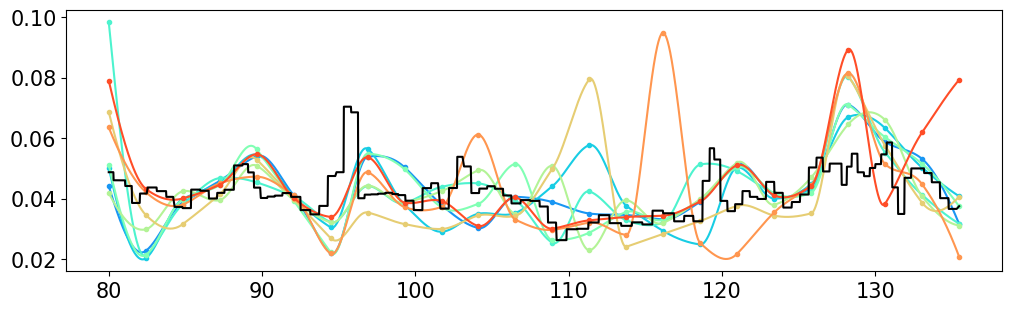

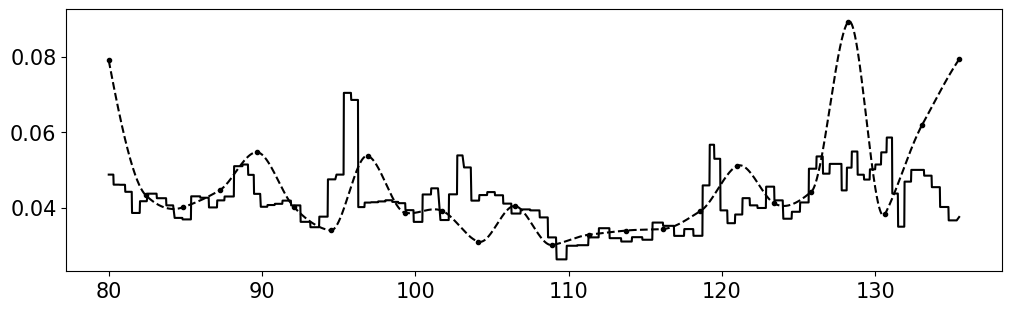

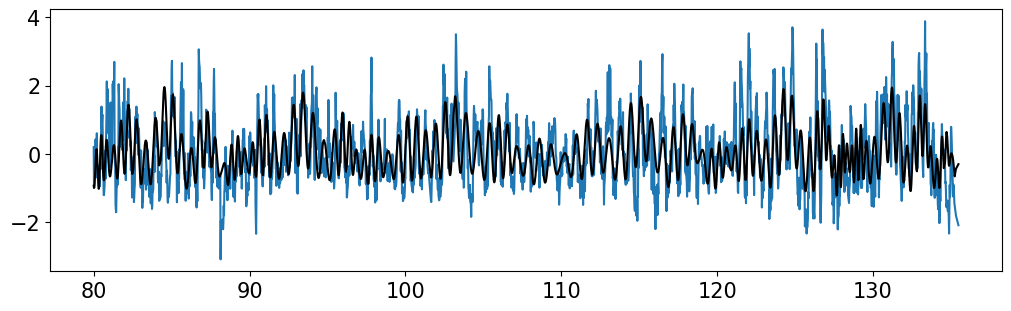

In [17]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
ax.plot(depth, func_invSR_nominal(depth),color="black",zorder=100)
cmap = plt.get_cmap("rainbow")

for i, res in enumerate(res_ensemble):
    if i<2:
        continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    ax.plot(depth, interpolator([depth_genes, res.X[arg_best]], depth), color=cmap(i/N_ensemble))
    ax.plot(depth_genes, res.X[arg_best], '.', color=cmap(i/N_ensemble))




fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
ax.plot(depth, func_invSR_nominal(depth),color="black")
i = -1
res = res_ensemble[i]
depth_genes = depth_genes_ensemble[i]
arg_best = np.argmin(res.F.mean(axis=1))
print(-res.F[arg_best])
ax.plot(depth, interpolator([depth_genes, res.X[arg_best]], depth), "--", color="black")
ax.plot(depth_genes, res.X[arg_best], '.', color="black")
# ax.set_ylim(invSR_lims)

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))

time, y_pred = invSR_to_predx([depth_genes, res.X[arg_best]])
ax.plot(depth, y )
ax.plot(depth, y_pred, color="black")

# ax.plot(time, y )
# ax.plot(time, y_pred, color="black")

### got em

In [ ]:
invSR_lims = [0.02, 0.1]
fs = np.hstack([g_k + p0, fe_k])
# interpolator = interpolate_Akima
interpolator = interpolate_CubicSpline
invSR_to_predx =  partial(invSR_to_pred,  data=[depth, y], invSR_lims=invSR_lims, fs=fs, interpolator=interpolator)
n_pieces = 2
# metric_optimal = metric_piecewise([depth_genes, func_invSR_nominal(depth_genes)], [depth, y], fs, interpolator, n_pieces)
# print(metric_optimal)
# invSR_all = np.zeros((N_generations_max, N_population, N_genes))
# invSR_ini = np.random.rand(N_population, N_genes)*invSR_lims[1]
# invSR_all[0] = invSR_ini
# metric_all = np.zeros((N_generations_max, N_population))
# metric_ini = np.array([metric([depth_genes, invSR_ini_i], [depth, y], fs, interpolator, metric_type="BIC") for invSR_ini_i in invSR_ini])
# metric_all[0] = metric_ini
interpolator = interpolate_CubicSpline
data = [depth, y]
problem = invSRinference(depth_genes, invSR_lims, interpolator, data, fs, n_pieces=n_pieces, metric=metric_piecewise)
out = {}
problem._evaluate(np.random.rand(len(depth_genes)), out)
out

In [74]:
algorithm = NSGA2(
    pop_size=400,
    # n_offsprings=100,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)
N_generations = 1000
termination = get_termination("n_gen", N_generations)

N_genes_enemble = np.array([24]*32)
depth_genes_ensemble = [np.linspace(depth_lims[0], depth_lims[1], N_genes) for N_genes in N_genes_enemble] 
N_ensemble = len(depth_genes_ensemble)

# N_trial = 4
# N_genes_distinct = np.arange(2, 60, 2)
# N_genes_enemble = np.array([ np.array([i]*N_trial)  for i in  N_genes_distinct]).flatten()
# depth_genes_ensemble = [np.linspace(depth_lims[0], depth_lims[1],N_genes) for N_genes in N_genes_enemble] 
# N_ensemble = len(depth_genes_ensemble)


problems = [invSRinference(depth_genes, invSR_lims, interpolator, data, fs, n_pieces=2, metric=metric_piecewise) for depth_genes in depth_genes_ensemble  ] 


res_ensemble = Parallel(n_jobs=N_ensemble, verbose=100)(delayed(minimize)(problem, algorithm, termination, 
                                                                          save_history=False, callback=Callback_getF())
                                                        for problem in problems)

opt_max_ensemble = np.zeros([N_ensemble,N_generations])
for i in range(N_ensemble):
    res = res_ensemble[i]
    opt_max_ensemble[i] = -np.array(res.algorithm.callback.data["best"])
ind_sort = np.argsort(opt_max_ensemble[:,-1])
res_ensemble = [res_ensemble[i] for i in  ind_sort]
opt_max_ensemble = opt_max_ensemble[ind_sort]

[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   1 tasks      | elapsed: 58.6min
[Parallel(n_jobs=32)]: Done   2 out of  32 | elapsed: 59.4min remaining: 891.3min
[Parallel(n_jobs=32)]: Done   3 out of  32 | elapsed: 64.3min remaining: 621.2min
[Parallel(n_jobs=32)]: Done   4 out of  32 | elapsed: 64.5min remaining: 451.7min
[Parallel(n_jobs=32)]: Done   5 out of  32 | elapsed: 64.9min remaining: 350.2min
[Parallel(n_jobs=32)]: Done   6 out of  32 | elapsed: 65.0min remaining: 281.6min
[Parallel(n_jobs=32)]: Done   7 out of  32 | elapsed: 66.2min remaining: 236.3min
[Parallel(n_jobs=32)]: Done   8 out of  32 | elapsed: 71.7min remaining: 215.1min
[Parallel(n_jobs=32)]: Done   9 out of  32 | elapsed: 71.8min remaining: 183.5min
[Parallel(n_jobs=32)]: Done  10 out of  32 | elapsed: 71.9min remaining: 158.2min
[Parallel(n_jobs=32)]: Done  11 out of  32 | elapsed: 72.6min remaining: 138.6min
[Parallel(n_jobs=32)]: Done  12 out of  3

Text(0.5, 0, 'number of generations')

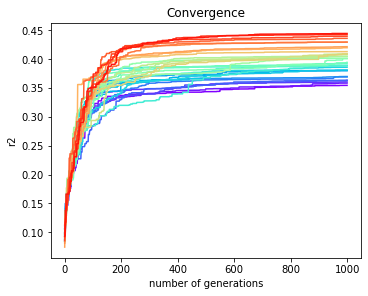

In [98]:
# opt = -np.array([e.opt[0].F for e in res.history])
# opt_mean = np.array([ np.mean([-eiopt.F for eiopt in e.opt]) for e in res.history])
%matplotlib inline
fig = plt.figure(constrained_layout=True, figsize=(5,4))
plt.title("Convergence")
# gs1 = fig.add_gridspec(nrows=1, ncols=2, hspace=0.05, wspace=0.05,
                    #    height_ratios=(6, 4), width_ratios=(35, 65))
# ax1 = fig.add_subplot(gs1[0, 0])
# ax2 = fig.add_subplot(gs1[0, 1])
plt.subplot(1,1,1)

cmap = plt.get_cmap("rainbow")

for i in range(N_ensemble):

    plt.plot(opt_max_ensemble[i], color=cmap(i/N_ensemble))


# metric_optimal = metric_piecewise([depth, func_inv_SR(depth)], [depth, y], fs, interpolator, n_pieces)
plt.ylabel("r2")
plt.xlabel("number of generations")
# plt.ylim([0.1, 0.8])
# plt.axhline(metric_optimal.mean(), color="k")

# # plt.yscale("log"),zorder=-10)
# plt.axhline(metric_optimal.mean(), color="k")

# plt.xlabel("number of genes")
# plt.ylabel("r2")
# plt.ylim([0.1, 0.8])
# # plt.savefig("r2_Ngenesb.png", dpi=200)

[0.36431536 0.52112357]
0.45351124552339805


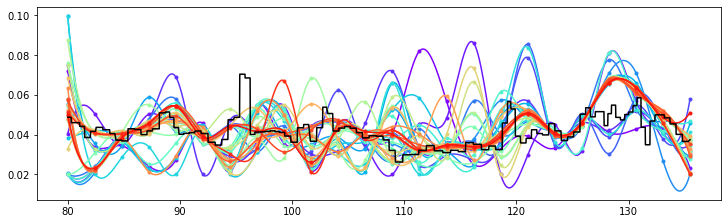

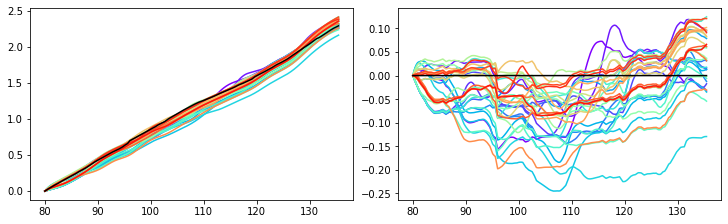

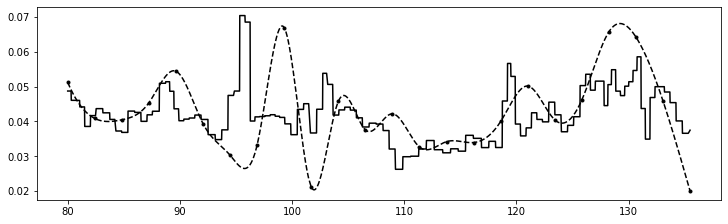

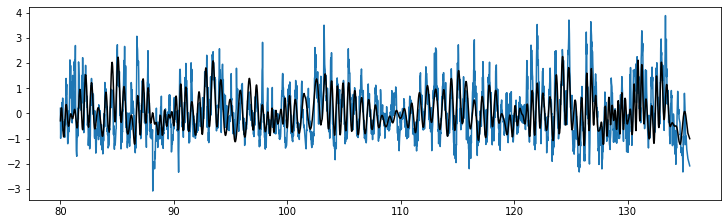

In [103]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
ax.plot(depth, func_invSR_nominal(depth),color="black",zorder=100)
cmap = plt.get_cmap("rainbow")

for i, res in enumerate(res_ensemble):
    # if i<2:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    ax.plot(depth, interpolator([depth_genes, res.X[arg_best]], depth), color=cmap(i/N_ensemble))
    ax.plot(depth_genes, res.X[arg_best], '.', color=cmap(i/N_ensemble))

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10,3))
cmap = plt.get_cmap("rainbow")
for i, res in enumerate(res_ensemble):
# for i, res in enumerate(reversed(res_ensemble)):
    # if i<2:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    time, y_pred = invSR_to_predx([depth_genes, res.X[arg_best]])
    axs[0].plot(depth, time, color=cmap(i/N_ensemble))
    axs[1].plot(depth, time-func_time_nominal(depth)+func_time_nominal(depth[0]), color=cmap(i/N_ensemble))
axs[0].plot(depth, func_time_nominal(depth)-func_time_nominal(depth[0]), color="black")
axs[1].plot(depth, depth*0, color="k")

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
ax.plot(depth, func_invSR_nominal(depth),color="black")
# i = -15
i = -2

res = res_ensemble[i]
depth_genes = depth_genes_ensemble[i]
arg_best = np.argmin(res.F.mean(axis=1))
print(-res.F[arg_best])
ax.plot(depth, interpolator([depth_genes, res.X[arg_best]], depth), "--", color="black")
ax.plot(depth_genes, res.X[arg_best], '.', color="black")
# ax.set_ylim(invSR_lims)

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))

time, y_pred = invSR_to_predx([depth_genes, res.X[arg_best]])
ax.plot(depth, y )
ax.plot(depth, y_pred, color="black")
print(r2_score(y, y_pred))
# ax.plot(time, y )
# ax.plot(time, y_pred, color="black")

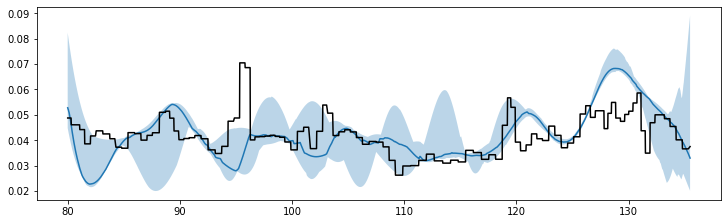

In [112]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
N_indi = 20
res_ensemblex = res_ensemble[-8:]
invSR_pop = np.zeros([len(depth), len(res_ensemblex), N_indi])
for i, res in enumerate(res_ensemblex):
    # if i<2:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    for j in range(N_indi):
        arg_best = np.argmin(res.F.sum(axis=1))
        invSR_pop[:, i, j] = interpolator([depth_genes, res.X[j]], depth)
        # ax.plot(depth, interpolator([depth_genes, res.X[j]], depth), color="black",alpha=0.1)
        # ax.plot(depth_genes, res.X[j], '.', alpha=0.1, color="black")
invSR_pop = invSR_pop.reshape(len(depth), -1)
ax.plot(depth, np.median(invSR_pop,axis=-1))
ax.fill_between(depth, *np.quantile(invSR_pop, [0.1, 0.9], axis=-1), alpha=0.3)
ax.plot(depth, func_invSR_nominal(depth),color="black",zorder=100)


# MCMC

## In search for SR

In [140]:
arg_best = np.argmin(res.F.sum(axis=1))
invSR_best = res.X[arg_best]
invSR_random = np.random.randn(N_genes)*(invSR_lims[1]-invSR_lims[0]) + invSR_lims[0]

nwalkers = 48
params_noise_ini = [0.8, 0.8]
params_ini = np.hstack([params_noise_ini, invSR_best])
pos = params_ini + 1e-4 * np.random.randn(nwalkers, N_genes+len(params_noise_ini))
# pos = invSR_random + 1e-4 * np.random.randn(nwalkers, N_genes)

nwalkers, ndim = pos.shape
log_posterior = log_posterior_rednoise_v1
log_probability_testcase = partial(log_posterior, depth_invSR=depth_genes, data=[depth, y], fs=fs, interpolator=interpolator, invSR_lims=invSR_lims) 

# log_posterior = log_posterior_whitenoise
# log_probability_testcase = partial(log_posterior, depth_invSR=depth_genes, data=[depth, y],interpolator=interpolate_CubicSpline,
#                                    invSR_lims=invSR_lims, sigma_lims=[1e-4, 2], prior_freq=prior_params_freq) 

# with Pool(processes=1) as pool:

with JoblibPool(16) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_testcase, pool=pool)
    sampler.run_mcmc(pos, 10000, progress=True)
    # print("Multiprocessing took {0:.1f} seconds".format(multi_time))

100%|██████████| 10000/10000 [06:14<00:00, 26.74it/s]


In [92]:
# %lprun -f log_posterior_whitenoise_v1  log_posterior_whitenoise_v1(params_ini, depth_invSR=depth_genes, data=[depth, y],interpolator=interpolate_CubicSpline, invSR_lims=invSR_lims,  fs=fs)         
%lprun -f log_likelihood_whitenoise  log_likelihood_whitenoise([depth_genes, invSR_best], data=[depth, y],interpolator=interpolate_CubicSpline, invSR_lims=invSR_lims,  fs=fs, sigma=0.8)         
    

Timer unit: 1e-09 s

Total time: 0.0555837 s
File: /users/nhoanghoai/AstroGeo/routines_model.py
Function: log_likelihood_whitenoise at line 244

Line #      Hits         Time  Per Hit   % Time  Line Contents
   244                                           def log_likelihood_whitenoise(invSR, data, fs, sigma, interpolator=interpolate_CubicSpline, *args, **kwargs):
   245                                               """_summary_: 
   246                                               
   247                                                   loglikelihood for the linear model with predictors variable are fourier harmonics of frequencies fs
   248                                                   of fitting the data, when used the age model derived from the invSR.
   249                                                   age model: given points of inverse SR, interpolate with an interpolator and integrate along depth
   250                                                   to obtain time.


In [115]:
samples.shape

(5000, 64, 18)

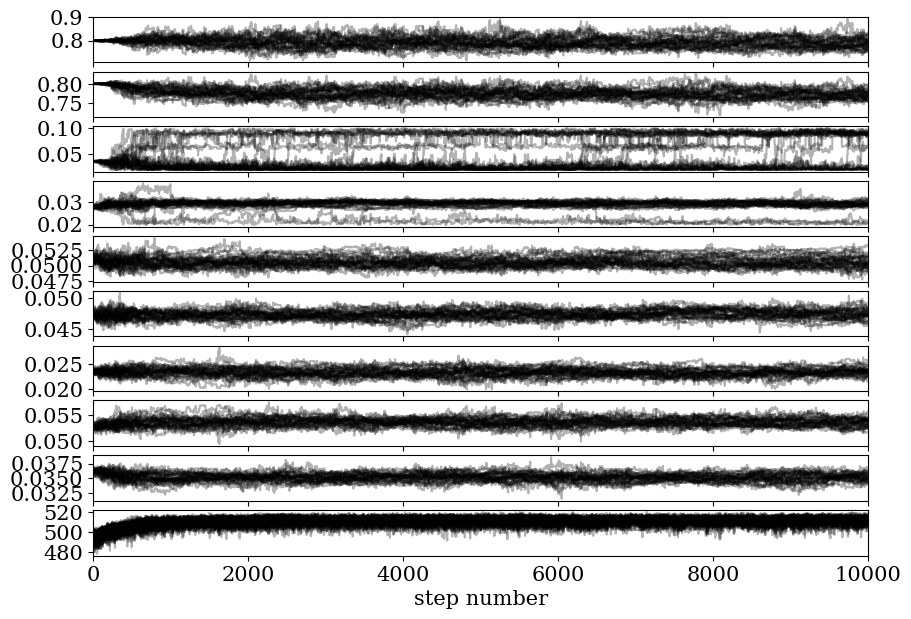

In [148]:
ndim = 10
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
logprob_sample = sampler.get_log_prob()

# labels = ["m", "b", "log(f)"]
for i in range(ndim-1):
    ax = axes[i]
    ax.plot(samples[:, :30, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    # ax.set_ylabel(labels[i])
    # ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].plot(logprob_sample, "k", alpha=0.3)
axes[-1].set_xlabel("step number");     

In [142]:
flat_samples = sampler.get_chain(discard=1000, thin=50, flat=True)
print(flat_samples.shape)

(8640, 18)


In [143]:
depth_genes.shape

(16,)

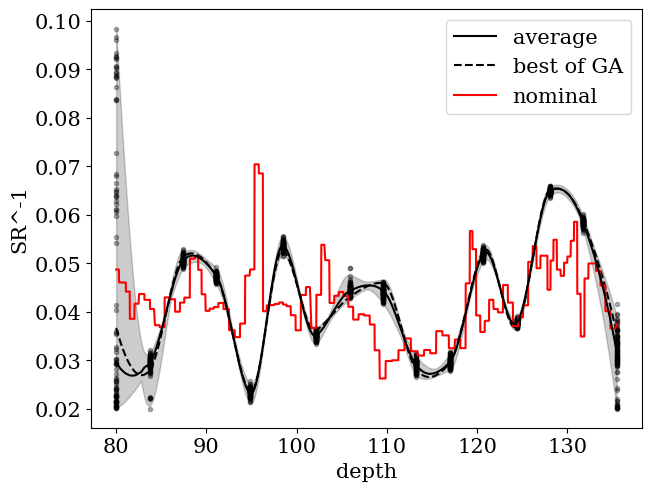

In [146]:
%matplotlib inline
inds = np.random.randint(len(flat_samples), size=4000)
# genes_value = flat_samples[:,1+len(freqs_true)+i]
invSR_interpolate_par = np.array([interpolator([depth_genes, flat_samples[i,len(params_noise_ini):]], depth) for i in range(8000)])
# invSR_interpolate_par = invSR_interpolate_par[metric_best<500]

# invSR_par = [invSR_all[-1][0] for invSR_all in invSR_all_para]
mean_invSR = np.median(invSR_interpolate_par,axis=0)
alphas = [0.025, 0.975]
alphas = [0.01, 0.99]
invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, alphas,axis=0)

fig1 = plt.figure(constrained_layout=True)
# plt.title(f"estimation from {n_para} populations")
plt.plot(depth, mean_invSR, zorder=10,color="black", label="average")
[plt.plot(depth_genes, flat_samples[i,len(params_noise_ini):],'.',alpha=0.3,color="black") for i in range(100) ]
plt.plot(depth, interpolator([depth_genes, invSR_best], depth), "--", color="black", label="best of GA")
plt.plot(depth, func_invSR_nominal(depth), label="nominal", color="red")
plt.fill_between(depth, invSR_lo, invSR_up, alpha=0.2, color="black")
# plt.plot(depth, invSR, "--", color="red", label="true")
# plt.xlim([90,125])
plt.xlabel("depth")
plt.ylabel("SR^-1")
plt.legend()

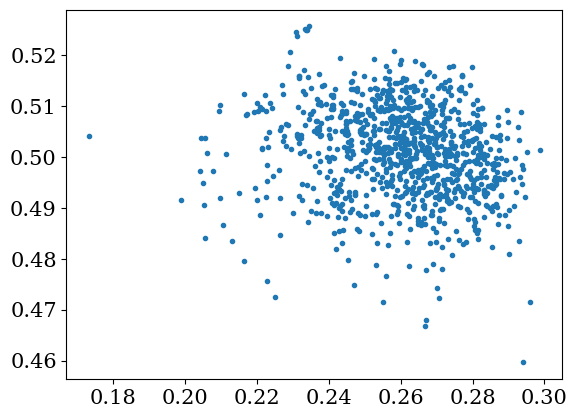

In [151]:
metric_samples = np.array([metric_piecewise([depth_genes, flat_samples[i,len(params_noise_ini):]], [depth, y], fs, interpolator, n_pieces)for i in range(1000) ])
# metr
# plt.figure()
# plt.hist(metric_samples.mean(axis=1))
# plt.hist(metric_samples[:,0])
# plt.hist(metric_samples[:,1])
plt.figure()
# plt.hist(metric_samples.mean(axis=1))
plt.plot(metric_samples[:,0], metric_samples[:,2], '.')
# plt.hist(metric_samples[:,1])

## In search for frequencies

In [155]:
prior_params_freq = np.array([[50.5, 10], [5.525, 0.125], [7.455, 0.015], [17.3, 0.15], [17.85, 0.15], [4.257564, 0.00002]])
prior_params_freq = prior_params_freq/180/3600*np.pi*1e6

In [167]:
log_posterior = log_posterior_whitenoise_EP
log_posterior = log_posterior_rednoise_EP

arg_best = np.argmin(res.F.sum(axis=1)/2)
invSR_best = res.X[arg_best]
invSR_random = np.random.randn(N_genes)*(invSR_lims[1]-invSR_lims[0]) + invSR_lims[0]

nwalkers = 80
params_noise_ini = [0.7, 0.7]
params_freq_ini = prior_params_freq[:,0]
params_ini = np.hstack([params_noise_ini, params_freq_ini, invSR_best])
# params_best = np.hstack([sigma_true, p0, muy_k, true_genes])
pos_ini = params_ini + 1e-4 * np.random.randn(nwalkers, len(params_ini))
# pos = invSR_random + 1e-4 * np.random.randn(nwalkers, N_genes)

nwalkers, ndim = pos_ini.shape
log_probability_testcase = partial(log_posterior, depth_invSR=depth_genes, data=[depth, y],interpolator=interpolate_CubicSpline,
                                   invSR_lims=invSR_lims, sigma_lims=[1e-4, 2], prior_freq=prior_params_freq) 

print(f"log posterior initial point: {log_probability_testcase(pos_ini[0])}")
# print(f"log posterior best point: {log_probability_testcase(params_best)}")


with Pool(processes=16) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_testcase, pool=pool)
    sampler.run_mcmc(pos_ini, 10000, progress=True)


log posterior initial point: 416.089548868899


100%|██████████| 10000/10000 [08:00<00:00, 20.82it/s]


In [168]:
print("acceptance_fraction", sampler.acceptance_fraction.mean())
tau = sampler.get_autocorr_time()
print("autocorr_time",tau)

acceptance_fraction 0.16888625


AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 24 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [ 658.77144028  700.13862949  694.61875384  765.55482326  610.23919304
  671.04527797  639.19991204  549.09686636 1078.54830882  895.19672211
  710.95563524  628.57597225  605.25580108  599.17826315  676.21455452
  606.38598733  723.90103252  561.50185962  544.08979847  542.93912176
  606.38559909  618.38172515  629.76914621  618.47754809]

In [169]:
samples = sampler.get_chain()
logprob_sample = sampler.get_log_prob()
samples.shape

(10000, 80, 24)

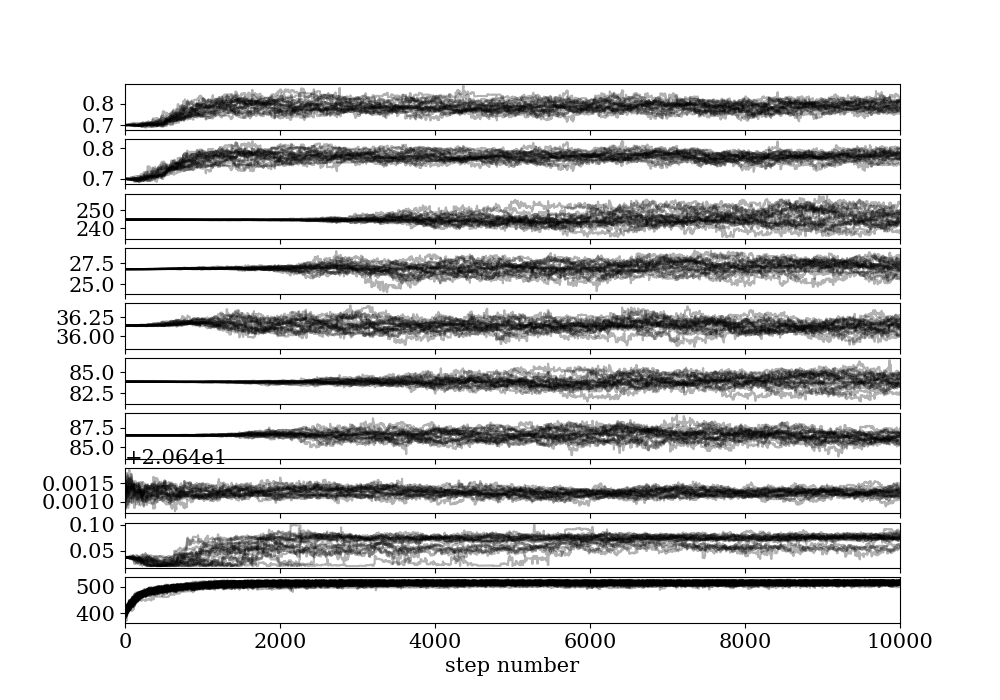

In [170]:
ndim = 10
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)

# labels = ["m", "b", "log(f)"]
for i in range(ndim-1):
    ax = axes[i]
    ax.plot(samples[:, :20, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    # ax.set_ylabel(labels[i])
    # ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].plot(logprob_sample, "k", alpha=0.3)
axes[-1].set_xlabel("step number");     

In [174]:
flat_samples = sampler.get_chain(discard=2000, thin=200, flat=True)

In [1]:
fs

NameError: name 'fs' is not defined

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(8,4),constrained_layout=True)
coef = 1/180/3600*np.pi*1e6
freqs_0 = np.hstack([p0, g_k])/coef
for i, ax in enumerate(axs.flatten()):

    # variance = 1
    # sigma = math.sqrt(variance)
    muy, sigma = prior_params_freq[i]/coef
    x = np.linspace(muy - 3*sigma, muy + 3*sigma, 100)
    ax.plot(x, sp.stats.norm.pdf(x, muy, sigma))
    ax.hist(flat_samples[:,len(params_noise_ini)+i]/coef, density=True, color="k", alpha=0.5, bins=25)
    ax.axvline(freqs_0[i], ls="--", color="red")
    # plt.plot(depth, interpolator([depth_genes, invSR_best], depth), "--", color="black", label="best")
    
    # ax.hist(2*np.pi/(flat_samples[:,1+i]+flat_samples[:,1])*1e3, density=True, color="k", alpha=0.5, bins=25)
    # ax.axvline(2*np.pi/fs[i-1]*1e3)
axs[0,0].set_xlim(45,55)

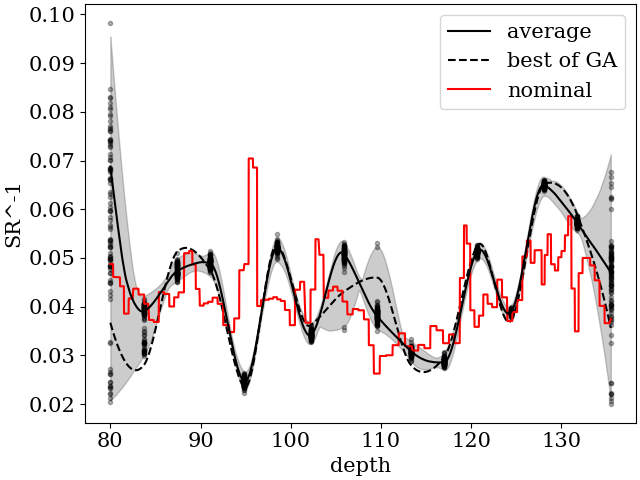

In [185]:
inds = np.random.randint(len(flat_samples), size=4000)
# genes_value = flat_samples[:,1+len(freqs_true)+i]
invSR_interpolate_par = np.array([interpolator([depth_genes, flat_samples[i,len(params_noise_ini)+6:]], depth) for i in range(3000)])
# invSR_interpolate_par = invSR_interpolate_par[metric_best<500]

# invSR_par = [invSR_all[-1][0] for invSR_all in invSR_all_para]
mean_invSR = np.median(invSR_interpolate_par,axis=0)
alphas = [0.025, 0.975]
alphas = [0.01, 0.99]
invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, alphas,axis=0)

fig1 = plt.figure(constrained_layout=True)
# plt.title(f"estimation from {n_para} populations")
plt.plot(depth, mean_invSR, zorder=10,color="black", label="average")
[plt.plot(depth_genes, flat_samples[i,len(params_noise_ini)+6:],'.',alpha=0.3,color="black") for i in range(100) ]
plt.plot(depth, interpolator([depth_genes, invSR_best], depth), "--", color="black", label="best of GA")
plt.plot(depth, func_invSR_nominal(depth), label="nominal", color="red")
plt.fill_between(depth, invSR_lo, invSR_up, alpha=0.2, color="black")
# plt.plot(depth, invSR, "--", color="red", label="true")
plt.xlabel("depth")
plt.ylabel("SR^-1")
plt.legend()

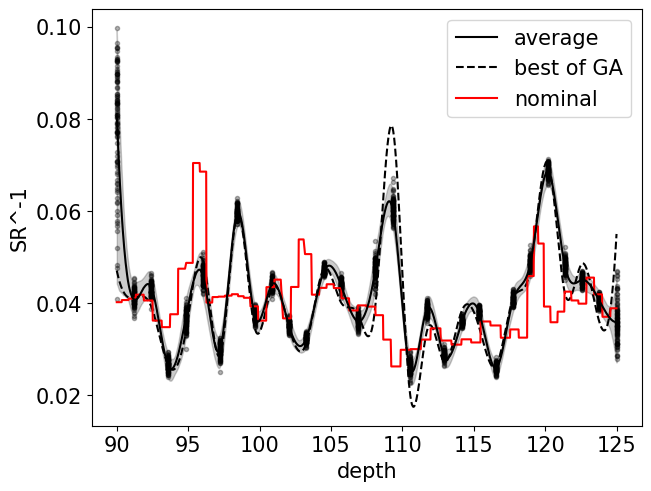

In [141]:
inds = np.random.randint(len(flat_samples), size=4000)
# genes_value = flat_samples[:,1+len(freqs_true)+i]
invSR_interpolate_par = np.array([interpolator([depth_genes, flat_samples[i,1+6:]], depth) for i in range(4000)])
# invSR_interpolate_par = invSR_interpolate_par[metric_best<500]

# invSR_par = [invSR_all[-1][0] for invSR_all in invSR_all_para]
mean_invSR = np.median(invSR_interpolate_par,axis=0)
alphas = [0.025, 0.975]
alphas = [0.01, 0.99]
invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, alphas,axis=0)

fig1 = plt.figure(constrained_layout=True)
# plt.title(f"estimation from {n_para} populations")
plt.plot(depth, mean_invSR, zorder=10,color="black", label="average")
[plt.plot(depth_genes, flat_samples[i,1+6:],'.',alpha=0.3,color="black") for i in range(100) ]
plt.plot(depth, interpolator([depth_genes, invSR_best], depth), "--", color="black", label="best of GA")
plt.plot(depth, func_invSR_nominal(depth), label="nominal", color="red")
plt.fill_between(depth, invSR_lo, invSR_up, alpha=0.2, color="black")
# plt.plot(depth, invSR, "--", color="red", label="true")
plt.xlabel("depth")
plt.ylabel("SR^-1")
plt.legend()

array([0.11036102, 0.12123117])

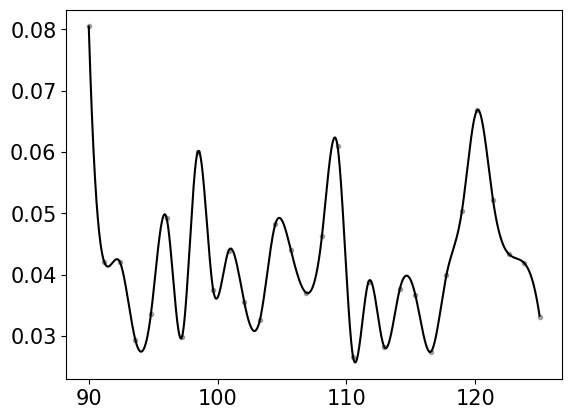

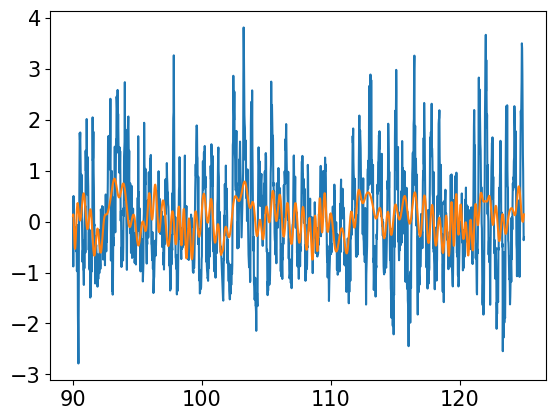

In [155]:
# fig1 = plt.figure(constrained_layout=True)
i= 2
plt.figure()
plt.plot(depth_genes, flat_samples[i,1+6:],'.',alpha=0.3,color="black")
plt.plot(depth, invSR_interpolate_par[i],color="black")
time, y_pred = invSR_to_predx([depth_genes, flat_samples[i,1+6:]])
plt.figure()
plt.plot(depth, y)
plt.plot(depth, y_pred)

metric_samples[2]

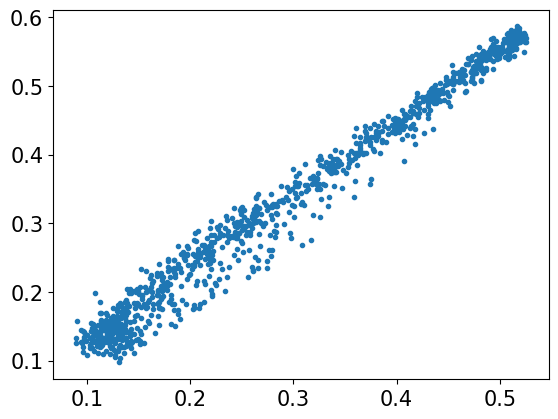

In [132]:
metric_samples = np.array([metric_piecewise([depth_genes, flat_samples[i,7:]], [depth, y], fs, interpolator, n_pieces)for i in range(1000) ])
# metr
# plt.figure()
# plt.hist(metric_samples.mean(axis=1))
# plt.hist(metric_samples[:,0])
# plt.hist(metric_samples[:,1])
plt.figure()
# plt.hist(metric_samples.mean(axis=1))
plt.plot(metric_samples[:,0], metric_samples[:,1], '.')
# plt.hist(metric_samples[:,1])

In [103]:
y_pred_sample.shape

(1000, 1694)

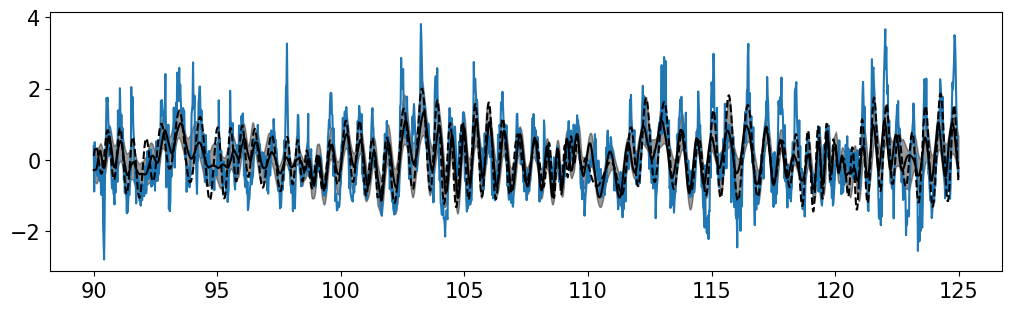

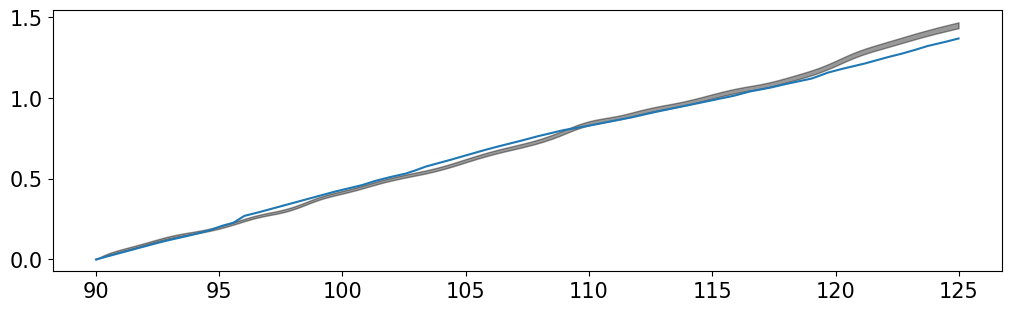

In [122]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
ax.plot(depth, y)

y_pred_sample =  np.array([ invSR_to_predx([depth_genes, flat_samples[i,7:]])[1] for i in range(1000)])
alphas = [0.01, 0.99]
alphas = [0.05, 0.95]

ypred_lo, ypred_up = np.quantile(y_pred_sample, alphas,axis=0)

time_best, y_pred = invSR_to_predx([depth_genes, invSR_best])
# axs[0].plot(depth, time, color="black")
# 
ax.plot(depth, y_pred, "--", color="black")
ax.fill_between(depth, ypred_lo, ypred_up, color="black", alpha=0.4)
ax.plot(depth, np.median(y_pred_sample, axis=0), color="black")

# ax.set_xlim([90,100])
# time_nominal, y_pred = invSR_to_predx([depth_genes, func_invSR_nominal(depth_genes)])


fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
time_sample =  np.array([ invSR_to_predx([depth_genes, flat_samples[i,7:]])[0] for i in range(1000)])
alphas = [0.05, 0.95]
lo, up = np.quantile(time_sample, alphas,axis=0)
ax.fill_between(depth, lo, up, color="black", alpha=0.4)
ax.plot(depth, func_time_nominal(depth)-func_time_nominal(depth[0]))


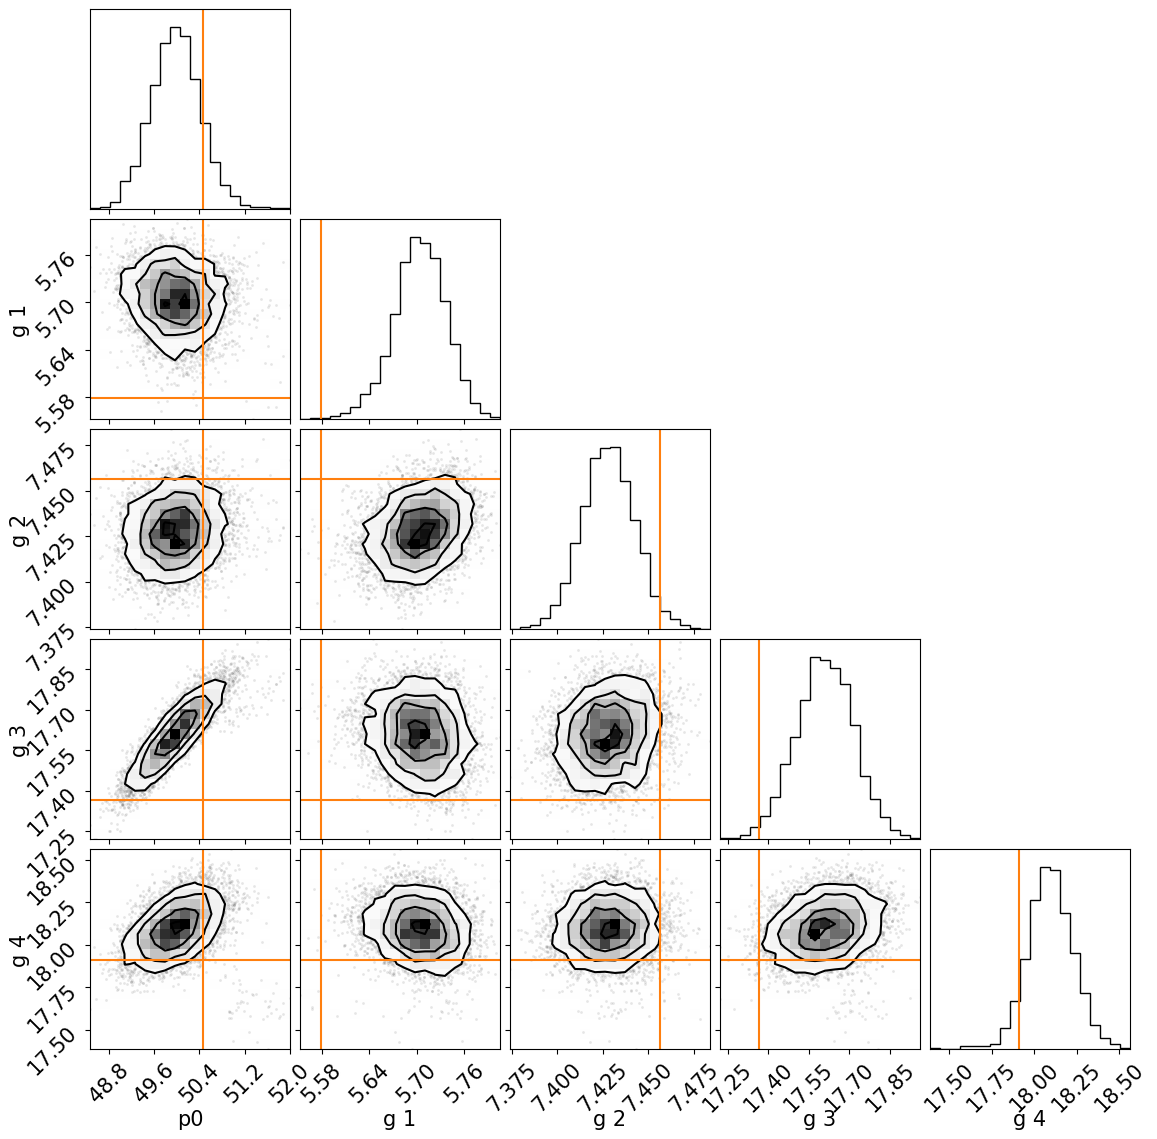

In [68]:
# labels = list(map(r"invSR{0}".format, range(1, N_genes + 1)))
# n_genes_plot = N_genes
n_genes_plot = 5
coef = 1/180/3600*np.pi*1e6

# true_values = np.hstack([[sigma_true, rho_true], true_genes[:n_genes_plot]])
labels = ["p0"] + [f"g {i}" for i in range(1,5)]
fig = corner.corner(
    flat_samples[:,1:6]/coef, labels=labels
)
corner.overplot_lines(fig, np.hstack([p0, g_k[:4]])/coef, color="C1",label="GA")
# corner.overplot_lines(fig, invSR_best[:n_genes_plot], color="C1",label="GA")
# corner.overplot_points(fig, invSR_best[None,:n_genes_plot], marker="s", color="C1")
# plt.legend()